# Students in Motion: An Analysis of MRT and Bus Services to Singapore Polytechnic (PDAS)

## Preface
Singapore Polytechnic is the only polytechnic in Singapore to have a Mass Rapid Transit (MRT) station directly connected to it. As such, it is the primary method of commute for most SP students. However, there are many students who still take one of at least twelve bus services to SP. 

Access to SP is usually via follows:
### MRT
- Access via Dover MRT station, which directly connects to Singapore Polytechnic's Plaza.

### Bus Services 
- Two Primary Bus Stops service Singapore Polytechnic
    - Dover MRT Bus Stop (this is the primary bus stop as advertised by SP during on the web site):
    
        Bus Services: 14, 74, 74e, 105, 106, 147, 166, 185, NR5, NR8
    - Alongside Commonwealth Ave West Bus Stop (outside Block T1A): (will not be the subject of study)

        Bus Services: 14, 74, 74e, 105, 106, 147, 166, 185, NR5, NR8.

In recent years, there have been increased concern as to the issue of overcrowding in the system.
In April 2020, the Land Transport Authority (LTA) had to increase the frequency of trains admist complaints about overcrowding in certain stations. In the case of SP students, such issues could lead to reduced quality of life, being late due to delays caused when trains/buses have to wait longer for passengers to get in, or in the current COVID-19 situation, contracting COVID-19 in an overcrowded environment.

Hence, there is a need to reexamine and possibly improve how students travel to SP, to improve the lives of students and ensure SP is the premier polytechnic in Singapore.

Sources:

[Directions to Singapore Polytechnic](https://www.sp.edu.sg/sp/about-sp/visit-us/directions-to-sp)

[LTA Modifies MRT Frequency to Address Crowding, The Straits Times](https://www.straitstimes.com/singapore/transport/lta-modifies-mrt-frequency-to-address-crowding)

[Crowding in public transport systems: effects on users, operation and implications for the estimation of demand](https://core.ac.uk/download/pdf/212686323.pdf)

## What do we want to find out?
- Examine how public transport ridership has evolved over time, to see if there is a need to make improvements in the accessibilty of SP via public transport.
- Discover the distribution and trends of people travelling to SP via MRT & Bus, and if possible, compare it to the usual commute patterns of other riders (specifically, office workers). This will let us determine if there is a need to increase bus/train frequency or change the scheduling of lessons to reduce demand on the public transport system.
- Examine the mean bus frequency of buses going to SP, to determine if it is necessary to adjust the bus frequency for certain timings.

## Importing Libraries

In [1]:
import numpy as np 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.font_manager
matplotlib.rcParams['mathtext.fontset'] = 'custom' # set LaTeX fonts
matplotlib.rcParams['mathtext.bf'] = 'Lato:bold'
import seaborn as sns
import zipfile # unzip files
import requests # make get requests to Datamall API
import os # to open file dir
from typing import List, Union, Tuple
from scipy.stats import normaltest 
# import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 150 # increase resolution of inline plots
sns.set(style = "whitegrid", font="Lato") # Set Theme and font
DataFrame = pd.core.frame.DataFrame # define type alias
Series = pd.core.frame.Series 
Figure = matplotlib.figure.Figure
Subplot = matplotlib.axes._subplots.Axes
LTA_API_KEY = "iIjmlFM/RRGXIjsjY5KTnA=="  # LTA Datamall Auth Token
dates = ["202010", "202011", "202012"] # Months of data to get from LTA Datamall ("202101" is unavailable) 

## Utility Functions

In [2]:
def get_transport_data_zip(url : str, dates: List[str], zipName: str, token: str, skipDownload : bool = False) -> DataFrame:
    """
    Utility function for getting zip file from LTA Datamall api, extracting data, then merging them together. This only works on certain LTA datamall apis: those that return a link to download a zip file. It also assumes all files inside the zip are csv files.

    Parameters:
        url = API url for get request
        dates = List of dates where each date has the format "YYYYMM", tells datamall which dates to get data from
        zipName = Specify the name of the zipfile to be saved. Final name of file will be zipName+date.zip
        token = LTA Datamall API Key
        skipDownload = if file is already downloaded, we can skip downloading again to avoid hitting the API rate limit
    
    Returns:
        Merged dataset from all dates
    """
    try:
        assert type(url) is str, "url should be a string"
        assert type(dates) is list, "dates should be a list of dates where each date has the format 'YYYYMM', tells datamall which dates to get data from"
        assert type(zipName) is str, "Specify the name of the zipfile to be saved. Final name of file will be zipName+date.zip"
        assert type(token) is str, "Token should be the LTA Datamall API Key as a string"
        assert type(skipDownload) is bool, "skipDownload should be a boolean value indicating if download of zip file should be skipped"
        files = []
        for date in dates:  
            if not skipDownload: # if file not already downloaded, download it from datamall
                req = requests.get(url, params = { "Date" : date }, headers = { "AccountKey" : token })
                print(req)
                req = req.json()
                link = req["value"][0]["Link"]
                req = requests.get(link, allow_redirects = True) # request will redirect to download link
                with open("{}{}.zip".format(zipName, date), "wb") as f: # creating a new file
                    f.write(req.content) # write file sent from request
            with zipfile.ZipFile("{}{}.zip".format(zipName, date)) as myzip:
                files += myzip.namelist() # get a list of all csv files in the zip file
                myzip.extractall() # extract all files
        data = [pd.read_csv("{}".format(filename)) for filename in files]
        return pd.concat(data, ignore_index= True) # return merged data
    except Exception as error:
        print(error)
        print(req)
        raise error

In [3]:
def outlierDetection(df : DataFrame, var : str, sort : bool = True) -> DataFrame:
    """
    Utilty function for detecting basic outliers. Prints out no. of outliers, shows first 5 outliers and displays a box plot. Outliers are defined in this case by Tukey's fences, where outliers are data points above or below the upper or lower quantiles by 1.5 * IQR.

    Parameters:
        df = DataFrame to detect outliers in
        var = name of column where outlier detection is performed
        sort = should the returned dataset be sorted?
    Returns:
        Dataset which only includes outliers
    """
    Q3 = df[var].quantile(0.75)
    Q1 = df[var].quantile(0.25)
    IQR = Q3 - Q1
    UpperFence = Q3 + 1.5 * IQR
    LowerFence = Q1 - 1.5 * IQR
    mask = (df[var] > UpperFence) | (df[var] < LowerFence)
    outlier_df = df[mask]
    if len(outlier_df) == 0:
        print("No Outliers")
    else:
        print("Outliers in Series (First 5)")
        print(outlier_df.head())
        print("No. of Outliers:", len(outlier_df))
    sns.boxplot(y = var,data = df, orient= "h")
    sns.despine(left = True)
    plt.title(f"Box Plot of {var}", fontdict = {
        "weight" : "semibold"
    })
    plt.show()
    if sort:
        return outlier_df.sort_values(var)
    else:
        return outlier_df

In [4]:
def plotAllOutliers(df: DataFrame, cols: Union[List[str], None] = None) -> Figure:
    cols = df.select_dtypes(include=np.number).columns.tolist() if cols is None else cols
    fig, ax = plt.subplots(len(cols), 1, figsize = (10, 6), tight_layout = True)
    for idx, col in enumerate(cols):
        sns.boxplot(df[col], ax = ax[idx])
    return fig

In [5]:
def removeOutliers(data: Union[DataFrame, Series], cols : Union[List[str], None] = None) -> DataFrame:
    df_type = type(data)
    assert df_type is DataFrame or df_type is Series, "data should either be a pandas dataframe or series"
    assert cols is None or type(cols) is list, "Either provide None, or a list of col names"
    if cols is not None:
        data = data[cols]
    Q3 = data.quantile(0.75)
    Q1 = data.quantile(0.25)
    IQR = Q3 - Q1
    print("Shape Before Removing Outliers:", data.shape)
    data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]
    print("Shape After Removing Outliers:", data.shape)
    return data

In [6]:
def normalityTest(data: Series, alpha: float = 0.05, plotQQ : bool = True, ignore_na : bool = True) -> Tuple[float, float]:
    """
    This function tests the null hypothesis that a sample comes from a normal distribution. It is based on  D’Agostino and Pearson’s, test that combines skew and kurtosis to produce an omnibus test of normality.
    """
    if plotQQ:
        sm.qqplot(data, line = "s") 
        try:
            plt.title("Q-Q Plot of {}".format(data.name), weight = "semibold", fontsize = 16)
        except:
            plt.title("Q-Q Plot", weight = "semibold", fontsize = 16)
        plt.show()
    k2, p = normaltest(data, nan_policy= "omit" if ignore_na else "raise")
    print("Null Hypothesis: Data Follows a Normal Distribution\nAlternative Hypothesis: Data Does Not Follow a Normal Distribution", end = "\n\n")
    print("Test Results:\np-value: {:.4f}\nTest Statistic: {:.4f}".format(p, k2), end = "\n\n")
    if p < alpha:
        print(f"Reject Null Hypothesis at \u03B1 = {alpha}%. Data does not follow a normal distribution.")
    else:
        print(f"Fail to reject Null Hypothesis at \u03B1 = {alpha}%.")
    return k2, p

## Objective 1: How has Public Transport ridership evolved over time?

### Dataset 1: Public Transport Utilisation - Average Daily Public Transport Ridership
- Average daily number of trips made islandwide on MRT, LRT, bus & taxi.


#### Loading the Data

In [7]:
daily_ridership = pd.read_csv("public-transport-utilisation-average-public-transport-ridership.csv", na_values = 0) # set all 0 values as na values, since it is impossible for mean daily ridership numbers to be 0 if it is available
daily_ridership.head()

,year,type_of_public_transport,average_ridership
0,1995,MRT,740000.0
1,1995,LRT,NaN
2,1995,Bus,3009000.0
3,1995,Taxi,NaN
4,1996,MRT,850000.0


In [8]:
daily_ridership.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      88 non-null     int64  
 1   type_of_public_transport  88 non-null     object 
 2   average_ridership         78 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


Rename columns

In [9]:
daily_ridership.rename(columns= {
    "year" : "Year",
    "type_of_public_transport" : "Type of Public Transport",
    "average_ridership" : "Mean Daily Ridership"
}, inplace= True)

#### Checking for Missing Values

In [10]:
is_na = daily_ridership.isna()
is_na.sum() # Count missing values

Year                         0
Type of Public Transport     0
Mean Daily Ridership        10
dtype: int64

There are 10 missing values in the data. What is the missing data?

In [11]:
daily_ridership[is_na.any(axis = 1)]

,Year,Type of Public Transport,Mean Daily Ridership
1,1995,LRT,NaN
3,1995,Taxi,NaN
5,1996,LRT,NaN
7,1996,Taxi,NaN
9,1997,LRT,NaN
11,1997,Taxi,NaN
13,1998,LRT,NaN
15,1998,Taxi,NaN
19,1999,Taxi,NaN
23,2000,Taxi,NaN


Taxi Data and LRT Data.

LRT data is missing as it only began operations in 1999.
Taxi data before 2001 is missing as according to data.gov.sg, the method of calculation of taxi ridership was revised in 2003, but only data from 2001 and onwards could be updated using this new method.

To make our analysis more accurate then, we will remove all null values since we are not really concerned with the years with null values.

In [12]:
print("Shape before removing na values:", daily_ridership.shape)
daily_ridership = daily_ridership[daily_ridership["Year"] > 2000]
print("Shape after removing na values:", daily_ridership.shape)

Shape before removing na values: (88, 3)
Shape after removing na values: (64, 3)


#### Generating Summary Statistics

In [13]:
daily_ridership.describe()

,Year,Mean Daily Ridership
count,64.000000,6.400000e+01
mean,2008.500000,1.548078e+06
std,4.646214,1.251564e+06
min,2001.000000,3.900000e+04
25%,2004.750000,6.487500e+05
50%,2008.500000,1.045500e+06
75%,2012.250000,2.812000e+06
max,2016.000000,3.939000e+06


In [14]:
daily_ridership.pivot_table(values = "Mean Daily Ridership",index= "Type of Public Transport", aggfunc= [min, max, np.mean, np.median, np.std]) 

,min,max,mean,median,std
,Mean Daily Ridership,Mean Daily Ridership,Mean Daily Ridership,Mean Daily Ridership,Mean Daily Ridership
Type of Public Transport,,,,,
Bus,2779000.0,3939000.0,3262500.0,3198000.0,379866.818767
LRT,39000.0,180000.0,95125.0,89000.0,41607.491313
MRT,1071000.0,3095000.0,1911062.5,1740000.0,696802.073165
Taxi,805000.0,1020000.0,923625.0,938500.0,62332.308369


Buses are the most popular mode of PT, followed by MRT and Taxi
LRT (Light Rail Transit) is the least popular mode of PT (has lowest min, max, mean, median values)

MRT has the greatest standard deviation, ~twice that of buses.

### Checking for Outliers

No Outliers


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


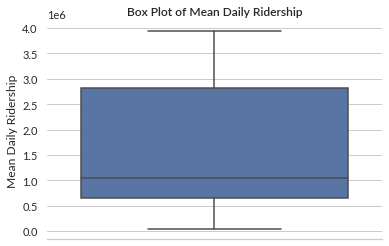

,Year,Type of Public Transport,Mean Daily Ridership


In [15]:
outlierDetection(daily_ridership, "Mean Daily Ridership")

No outliers were detected. However, we note that by itself, the overall distribution of ridership is positively skewed.
Can we verify if this is the same when split by transport type?

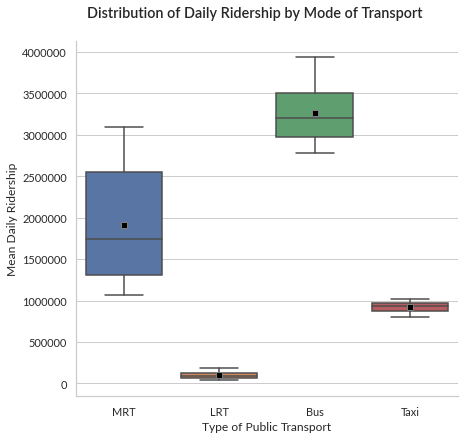

In [16]:
plot = sns.catplot(y = "Mean Daily Ridership", x = "Type of Public Transport", data = daily_ridership, kind="box", height = 6, showmeans = True, meanprops = {
    "marker" : "s",
    "markeredgecolor" : "gray",
    "markerfacecolor" : "black"
}) # produce a boxplot, with mean also shown
plot.fig.suptitle("Distribution of Daily Ridership by Mode of Transport", weight = "semibold")
plot.fig.subplots_adjust(top = 0.9) # adjust position of title to not overlap with graph
plot.ax.get_yaxis().get_major_formatter().set_scientific(False) # remove scientific notation for easier reading
plt.show()
# plot.fig.savefig("./plots/eda_by_mode.png", dpi = 200)

Once again, there are no outliers. However, we observe that while the MRT, LRT and Bus have positively skewed distributions, the Taxi actually has a negatively skewed ridership distribution.

MRT has the greatest spread as shown by its high interquartile range.

### Data Analysis

#### How has total ridership increased throughout the years?

<ipython-input-17-172bf9e7657f>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


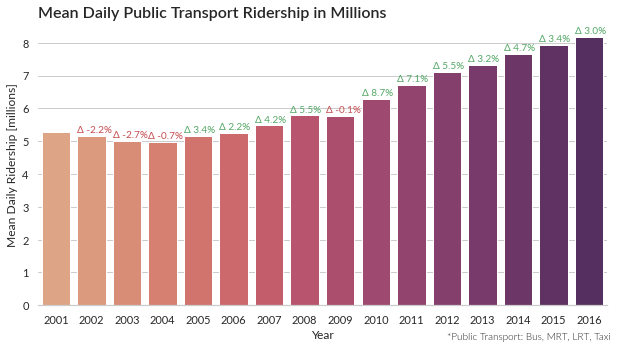

In [17]:
# Data Preprocessing
daily_ridership["Mean Daily Ridership [millions]"] = daily_ridership["Mean Daily Ridership"] / 1000000 # Create a new column using a millions based scale for ridership
total_ridership = daily_ridership.groupby("Year").sum() # get total ridership for each year
total_pct_change = total_ridership["Mean Daily Ridership"].pct_change() * 100 # calculate percentage change over the previous year

fig, ax = plt.subplots(figsize = (9, 5), tight_layout = True)

# Plot
sns.barplot(x = total_ridership.index, y= "Mean Daily Ridership [millions]", data = total_ridership, palette= "flare", ax = ax)

# Annotation & Visuals
ax.set_title("Mean Daily Public Transport Ridership in Millions", loc = "left", fontsize = 16, weight="semibold")
ax.text(11, -1.05, "*Public Transport: Bus, MRT, LRT, Taxi", weight="light", fontsize = 10)
sns.despine(left = True)
pct_annot = [ax.text(s = f"\u0394 {pct_change:.1f}%", x = idx - 0.4,  y= y + 0.1, fontsize = 10, color = 'r' if pct_change < 0 else 'g') for idx, (y, pct_change) in enumerate(zip(total_ridership["Mean Daily Ridership [millions]"].iloc[1:], total_pct_change.iloc[1:]), 1)]
fig.show()
# fig.savefig("./plots/mean_annual_ridership.png", dpi = 200)

#### Insights
Overall, there has been an increasing trend in public transport ridership. Mean daily ridership has increased from 5.2 million in 2001 to 8.1 million in 2016. 

The years 2010 to 2016 have seen a continual consecutive increase in ridership.

Notably, this increase in ridership appears to have outpaced population growth in Singapore. According to SingStat, S’pores population was approx 4.1 million in 2001, growing to 5.6 million in 2016. (inclusive of non-citizens). This is an increase of 1.5 million (+36.6%), compared to an increase of 2.9 million in ridership (+55.8%).

This suggests that an increase in ridership is not just due to population growth.

Context:
"The Land Transport Master Plan 2013 set out goals to be achieved by 2030. A key goal is to increase the peak hour public transport mode share to 75%." - Ministry of Transport

Source: 

[Department of Statistics (SingStat)](https://www.singstat.gov.sg/find-data/search-by-theme/population/population-and-population-structure/latest-data)

[Ministry of Transport](https://www.mot.gov.sg/about-mot/land-transport/public-transport)

<ipython-input-18-0cb81f30e5d6>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


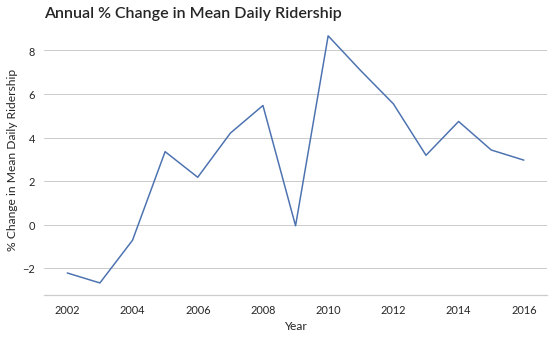

In [18]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.lineplot(data = total_pct_change)
ax.grid(False, axis = "x")
ax.set_title("Annual % Change in Mean Daily Ridership", loc = "left", weight ="semibold", fontsize = 16)
ax.set_ylabel("% Change in Mean Daily Ridership")
sns.despine(left = True)
fig.show()

Nevertheless, it does seem that population growth could play some factor in ridership. The sudden drop in mean daily ridership in 2009 coincided with a drop in Singapore's population growth rate by 2%. 

Source: [World Bank](https://data.worldbank.org/indicator/SP.POP.GROW?locations=SG)

#### Between the MRT and Bus, which is becoming more popular?

<ipython-input-19-37e469c2c640>:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


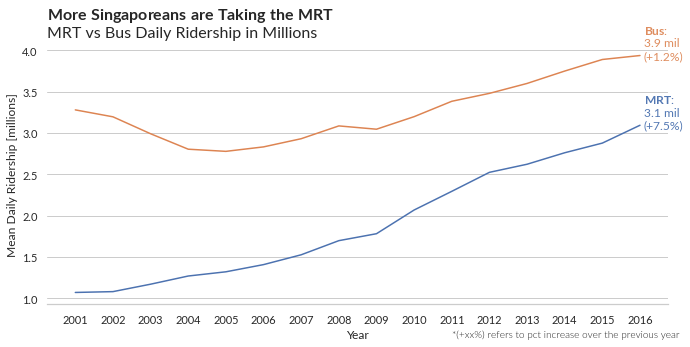

In [19]:
# Data Preprocessing
daily_ridership_df_busmrt = daily_ridership[daily_ridership["Type of Public Transport"].isin(["Bus", "MRT"])]
ridership_2016 = daily_ridership_df_busmrt.pivot("Year", "Type of Public Transport", "Mean Daily Ridership [millions]").iloc[-1, :]
bus2016, mrt2016 = ridership_2016
percentage_change = daily_ridership_df_busmrt.pivot(index = "Year", columns = "Type of Public Transport", values = "Mean Daily Ridership").pct_change() * 100
pct_change_bus, pct_change_mrt = percentage_change.iloc[-1, :]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5), tight_layout = True)
sns.lineplot(x = "Year", y= "Mean Daily Ridership [millions]", hue = "Type of Public Transport", data = daily_ridership_df_busmrt,ax = ax, legend = None)


# Annotation & Visuals
ax.annotate(r"$\bf{Bus}$:" + "\n{:.1f} mil\n(+{:.1f}%)".format(bus2016, pct_change_bus), (2016, bus2016), (2016.1, 3.89), color="#df8d5f")
ax.annotate(r"$\bf{MRT}$:" + "\n{:.1f} mil\n(+{:.1f}%)".format(mrt2016, pct_change_mrt), (2016, mrt2016), (2016.1, 3.05), color = "#5378b3")
ax.set_title(r"$\bf{More\ Singaporeans\ are\ Taking\ the\ MRT}$" + "\nMRT vs Bus Daily Ridership in Millions", loc = "left", fontsize = 16)
ax.text(2011, 0.53, "*(+xx%) refers to pct increase over the previous year", weight="light", fontsize = 10)
ax.grid(False, axis = "x") # remove vertical grid lines
# ax.legend(loc = "lower right", title = "Mode of Transport")
ax.set_xticks(daily_ridership["Year"].unique())
# ax.set_ylim(bottom = 0)
sns.despine(left = True)
fig.show()

<ipython-input-20-13fc4028b945>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


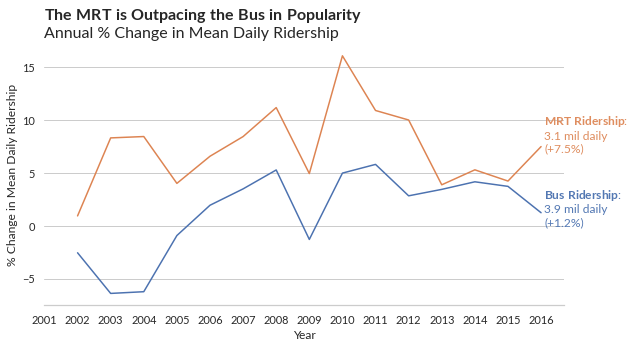

In [20]:
# Data Preprocessing
daily_ridership_df_busmrt = daily_ridership[daily_ridership["Type of Public Transport"].isin(["Bus", "MRT"])] # subset to only include bus and mrt ridership
ridership_2016 = daily_ridership_df_busmrt.pivot("Year", "Type of Public Transport", "Mean Daily Ridership [millions]").iloc[-1, :]
bus2016, mrt2016 = ridership_2016 # get ridership number for 2016
percentage_change = daily_ridership_df_busmrt.pivot(index = "Year", columns = "Type of Public Transport", values = "Mean Daily Ridership").pct_change() * 100 # perform a pivot, so that we can calculate percentage change over every year for each mode of transport
pct_change_bus, pct_change_mrt = percentage_change.iloc[-1, :] # get value of percentage change from last year in data (2016)

# Plotting
fig, ax = plt.subplots(figsize = (9, 5), tight_layout = True)
sns.lineplot(data = percentage_change, ax = ax, dashes= False, legend = None)

# Annotations & Visuals
ax.annotate(r"$\bf{Bus\ Ridership}$:" + "\n{:.1f} mil daily\n(+{:.1f}%)".format(bus2016, pct_change_bus), (2016, pct_change_bus), (2016.1, 0), color="#5378b3")
ax.annotate(r"$\bf{MRT\ Ridership}$:" + "\n{:.1f} mil daily\n(+{:.1f}%)".format(mrt2016, pct_change_mrt), (2016, pct_change_mrt), (2016.1, 7), color = "#df8d5f")
ax.grid(False, axis = "x") # remove vertical gridlines
ax.set_title(r"$\bf{The\ MRT\ is\ Outpacing\ the\ Bus\ in\ Popularity}$" + "\nAnnual % Change in Mean Daily Ridership", loc = "left", fontsize = 16)
ax.set_ylabel("% Change in Mean Daily Ridership")
ax.set_xticks(percentage_change.index) # show all years in x axis
sns.despine(left = True) 
fig.show()

In [21]:
fig.savefig("./plots/pct_change_ridership.png", dpi = 200)

#### Insights

Although bus ridership remains higher than MRT ridership (on average 800K more riders daily than MRT in 2016), it is clear that the MRT's ridership has been rapidly growing compared to the bus. The % change in mean daily ridership over the previous year for MRT has always consistenly been higher than the Bus, with a peak increase in 2010 by more than 15%.

In 2003 & 2004, there was a sudden dip in bus ridership (-ve % change), which was explained by one of the bus operators (SMRT) as being due to the impact of the SARS virus in Singapore. Notably, the MRT appears to have been largely unaffected by it, as ridership actually managed to increase during this period. A possible reason is that commuters felt safer taking the MRT due to the presence of temperature scanners in the stations, which could detect people with SARS, compared to bus stops where it would not be possible to check the temperature of everyone at every bus stop. Hence, the centralised nature of MRT stations likely contributed in it being mostly unaffected by SARS as it was easier to implement safety measures.

All this suggests that the MRT will continue to increase in popularity, especially as new lines are built. Thus, there is a need to ensure the MRT infrastructure can cope with this increased demand.

Source: [SMRT 2004 Annual Report](https://www.smrt.com.sg/Portals/0/PDFs/Annual%20Reports/2004_AR.pdf)

### Objective 1 Conclusions

#### Key Findings
- More Singaporeans are choosing public transport: Consistent increase in public transport ridership.
- The MRT, a Rising Star: A large part of this increase is from MRT ridership.
- Buses remain the most utilised form of transport. However their growth in ridership remains lower than the MRT.

#### How these findings will inform our later analysis
- While it is true that public transport ridership [decreased](https://www.straitstimes.com/singapore/transport/bus-train-ridership-in-singapore-falls-to-11-year-low-amid-covid-19-pandemic) as a result of COVID-19, it is likely that the numbers will return to pre-pandemic levels soon after vaccines are widely distributed.
- Rapidly rising public transport ridership provides some cause for our initial concern of overcrowding affecting SP students.
- Growth rate of MRT ridership suggests we should make recommendations with the assumptions that MRT will only become more packed in the future.
- Buses are still a viable option for transport to SP, and should not be completely ignored.

## Objective 2: What is commuter pattern of people who travel to SP by MRT?

### Dataset 2: PASSENGER VOLUME BY TRAIN STATIONS

- Tap in and tap out passenger volume by weekdays and weekends for individual train station
- By 15th of every month, the passenger volume for previous month data will be generated

### Loading the Data

In [22]:
station_volume_df = get_transport_data_zip("http://datamall2.mytransport.sg/ltaodataservice/PV/Train", dates, "transport_node_train_", LTA_API_KEY, True) # get data
station_volume_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-10,WEEKDAY,11,TRAIN,NS7,2353,1912
1,2020-10,WEEKENDS/HOLIDAY,11,TRAIN,NS7,1434,1940
2,2020-10,WEEKDAY,16,TRAIN,SW4,1033,1457
3,2020-10,WEEKENDS/HOLIDAY,16,TRAIN,SW4,514,522
4,2020-10,WEEKDAY,10,TRAIN,CC5,1319,3515


Rename Columns

In [23]:
station_volume_df.rename(columns = {
    "YEAR_MONTH" : "Year-Month",
    "DAY_TYPE" : "Day Type",
    "TIME_PER_HOUR" : "Time of Day",
    "PT_TYPE" : "Mode of Travel",
    "TOTAL_TAP_IN_VOLUME" : "Hourly Tap In Volume",
    "TOTAL_TAP_OUT_VOLUME" : "Hourly Tap Out Volume"
}, inplace = True)

In [24]:
station_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18984 entries, 0 to 18983
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Year-Month             18984 non-null  object
 1   Day Type               18984 non-null  object
 2   Time of Day            18984 non-null  int64 
 3   Mode of Travel         18984 non-null  object
 4   PT_CODE                18984 non-null  object
 5   Hourly Tap In Volume   18984 non-null  int64 
 6   Hourly Tap Out Volume  18984 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.0+ MB


### Checking for Missing data

In [25]:
station_volume_df.isna().sum()

Year-Month               0
Day Type                 0
Time of Day              0
Mode of Travel           0
PT_CODE                  0
Hourly Tap In Volume     0
Hourly Tap Out Volume    0
dtype: int64

Since there are no missing values, we will not need to drop any rows.

### Generating Summary Statistics

In [26]:
station_volume_df.describe(include="all")

,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume
count,18984,18984,18984.000000,18984,18984,18984.000000,18984.000000
unique,3,2,NaN,1,159,NaN,NaN
top,2020-11,WEEKDAY,NaN,TRAIN,EW5,NaN,NaN
freq,6328,9499,NaN,18984,120,NaN,NaN
mean,NaN,NaN,13.346660,NaN,NaN,8091.070375,8055.466761
std,NaN,NaN,6.100588,NaN,NaN,12979.937998,13053.073201
min,NaN,NaN,0.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,9.000000,NaN,NaN,942.000000,960.000000
50%,NaN,NaN,14.000000,NaN,NaN,3006.500000,2997.000000
75%,NaN,NaN,19.000000,NaN,NaN,9447.750000,9202.500000


On first glance, max values of tap in and out appear much higher than the upper quartile. This may indicate a high likelihood of outliers. 

In addition, the mean values of tap in and out are much higher than the median values. This indicates a positively skewed distribution.

### Total Volume and Net Volume 
- For further data analysis, we will create two new columns: Total Volume & Net Volume
- They are defined as follows:

$Total\ Volume = Total\ Tap\ In\ Volume + Total\ Tap\ Out\ Volume$
- Tells us of the overall demand in a station (how many people are there)

$Net\ Volume = Total\ Tap\ In\ Volume - Total\ Tap\ Out\ Volume$
- Tells us of the net movement of people in a station: are people mostly going in or out? (or do they balance out)

In [27]:
station_volume_df["Total Volume"] = station_volume_df["Hourly Tap In Volume"] + station_volume_df["Hourly Tap Out Volume"]

station_volume_df["Net Volume"] =  station_volume_df["Hourly Tap In Volume"] - station_volume_df["Hourly Tap Out Volume"]

station_volume_df.describe()

,Time of Day,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume
count,18984.000000,18984.000000,18984.000000,18984.000000,18984.000000
mean,13.346660,8091.070375,8055.466761,16146.537137,35.603614
std,6.100588,12979.937998,13053.073201,24137.763932,9751.480564
min,0.000000,0.000000,0.000000,1.000000,-111631.000000
25%,9.000000,942.000000,960.000000,2186.000000,-1195.250000
50%,14.000000,3006.500000,2997.000000,6613.500000,27.000000
75%,19.000000,9447.750000,9202.500000,19490.000000,1426.500000
max,23.000000,172514.000000,149809.000000,305091.000000,93486.000000


### Checking for Outliers

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel   PT_CODE  \
12    2020-10           WEEKDAY           18          TRAIN  EW24/NS1   
13    2020-10  WEEKENDS/HOLIDAY           18          TRAIN  EW24/NS1   
30    2020-10           WEEKDAY           17          TRAIN  NE7/DT12   
43    2020-10           WEEKDAY           14          TRAIN      EW27   
46    2020-10           WEEKDAY           18          TRAIN      DT27   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
12                167094                 127122        294216       39972  
13                 37152                  36741         73893         411  
30                 30763                  22242         53005        8521  
43                 29117                  34868         63985       -5751  
46                 22984                   8439         31423       14545  
No. of Outliers: 1850


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


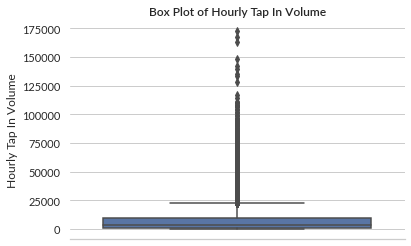

In [28]:
tap_in_outliers = outlierDetection(station_volume_df, "Hourly Tap In Volume")

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel   PT_CODE  \
12    2020-10           WEEKDAY           18          TRAIN  EW24/NS1   
13    2020-10  WEEKENDS/HOLIDAY           18          TRAIN  EW24/NS1   
15    2020-10           WEEKDAY            7          TRAIN      NE10   
17    2020-10           WEEKDAY            8          TRAIN      EW22   
30    2020-10           WEEKDAY           17          TRAIN  NE7/DT12   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
12                167094                 127122        294216       39972  
13                 37152                  36741         73893         411  
15                 17150                  22540         39690       -5390  
17                  7635                  38298         45933      -30663  
30                 30763                  22242         53005        8521  
No. of Outliers: 1959


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


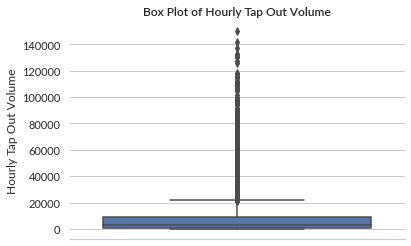

In [29]:
tap_out_outliers = outlierDetection(station_volume_df, "Hourly Tap Out Volume")

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel   PT_CODE  \
12    2020-10           WEEKDAY           18          TRAIN  EW24/NS1   
13    2020-10  WEEKENDS/HOLIDAY           18          TRAIN  EW24/NS1   
17    2020-10           WEEKDAY            8          TRAIN      EW22   
30    2020-10           WEEKDAY           17          TRAIN  NE7/DT12   
43    2020-10           WEEKDAY           14          TRAIN      EW27   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
12                167094                 127122        294216       39972  
13                 37152                  36741         73893         411  
17                  7635                  38298         45933      -30663  
30                 30763                  22242         53005        8521  
43                 29117                  34868         63985       -5751  
No. of Outliers: 1831


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


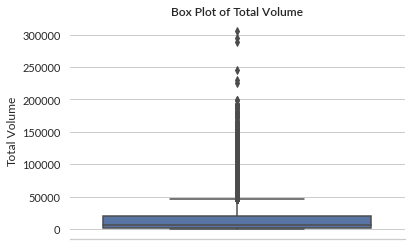

In [30]:
total_vol_outliers = outlierDetection(station_volume_df, "Total Volume")

Outliers in Series (First 5)
   Year-Month Day Type  Time of Day Mode of Travel       PT_CODE  \
12    2020-10  WEEKDAY           18          TRAIN      EW24/NS1   
15    2020-10  WEEKDAY            7          TRAIN          NE10   
17    2020-10  WEEKDAY            8          TRAIN          EW22   
23    2020-10  WEEKDAY            6          TRAIN  NS24/NE6/CC1   
30    2020-10  WEEKDAY           17          TRAIN      NE7/DT12   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
12                167094                 127122        294216       39972  
15                 17150                  22540         39690       -5390  
17                  7635                  38298         45933      -30663  
23                  2819                   8052         10871       -5233  
30                 30763                  22242         53005        8521  
No. of Outliers: 4093


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


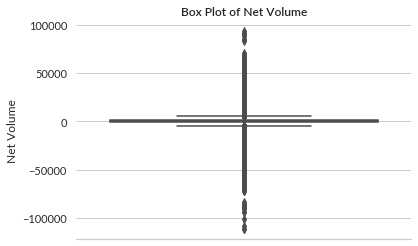

In [31]:
net_vol_outliers = outlierDetection(station_volume_df, "Net Volume")

Net Volume's distribution is more symmetrical and centers around 0 (median of 27).

#### What are the characteristics of the outliers?

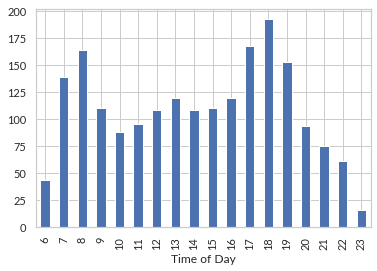

In [32]:
tap_out_outliers.groupby("Time of Day").size().plot(kind="bar")
plt.show()

Outliers for tap outs tend to cluster around two time periods: 7am to 10am and 4pm to 8pm, with the highest number of outliers (~ 190) being at 6pm. However, there are also many outliers in between the two clusters (although the peak is not as high)

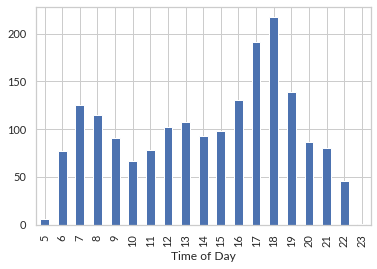

In [33]:
tap_in_outliers.groupby("Time of Day").size().plot(kind="bar")
plt.show()

The trend for tap in outliers is similar, with the same two clusters seen.

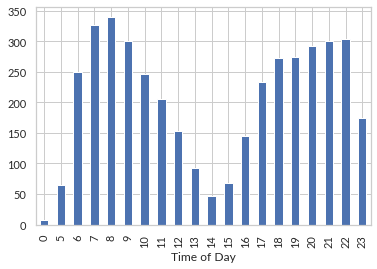

In [34]:
net_vol_outliers.groupby("Time of Day").size().plot(kind="bar")
plt.show()

The trend for net volume outliers also shows a bimodal distribution, but there are significantly more outliers (4093 outliers). 

In [35]:
total_vol_outliers.groupby("PT_CODE").size().nlargest(10)

PT_CODE
EW24/NS1     84
NS22         78
EW12/DT14    63
EW8/CC9      61
EW2/DT32     58
NS13         53
NS21/DT11    53
EW27         52
NS16         52
NS10         51
dtype: int64

The 5 top stations with the most outliers for total volume are:
- EW24/NS1: Jurong East
- NS22: Orchard
- EW12/DT14: Bugis
- EW8/CC9: Paya Lebar
- EW2/DT32: Tampines

Notably, 80% (4/5) of stations listed are part of the East West Line and are Interchanges (where two lines intersect)

In [36]:
net_vol_outliers.groupby("PT_CODE").size().nlargest(10)

PT_CODE
NS22         96
NS10         94
NE1/CC29     93
NS11         88
EW13/NS25    87
NS13         87
EW12/DT14    86
EW24/NS1     86
EW26         83
NS14         82
dtype: int64

The top 5 stations with most outliers for net volume shows a lower proportion of interchanges (2/5), and most being from the NS line (4/5)

Total Volume Outliers

In [37]:
total_vol_outliers["PT_CODE"].str.contains('/').sum() / len(total_vol_outliers) * 100 # how many outliers come from interchanges

47.62424904423812

In [38]:
total_vol_outliers["PT_CODE"].str.contains('EW').sum() / len(total_vol_outliers) * 100 # how many outliers come from stations in EW line?

38.83123975969416

In [39]:
total_vol_outliers["PT_CODE"].str.contains('NS').sum() / len(total_vol_outliers) * 100 # ditto for NS line

48.49808847624249

Net Volume Outliers

In [40]:
net_vol_outliers["PT_CODE"].str.contains('/').sum() / len(net_vol_outliers) * 100 # how many outliers come from interchanges

32.44563889567554

In [41]:
net_vol_outliers["PT_CODE"].str.contains('EW').sum() / len(net_vol_outliers) * 100 # how many outliers in net volume come from stations in EW line?

31.44392865868556

In [42]:
net_vol_outliers["PT_CODE"].str.contains('NS').sum() / len(net_vol_outliers) * 100  # ditto for NS line

37.06327876862937

Most occurances of outliers in hourly total volume come from the North South line (48.5%), followed by the East West Line (38.8%).

Around half (~47%) of all outliers (in terms of hourly total volume) are from stations that are interchanges. 

This suggests that some of the outliers could be due to the passenger volumes of the two lines being pooled together.

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\li

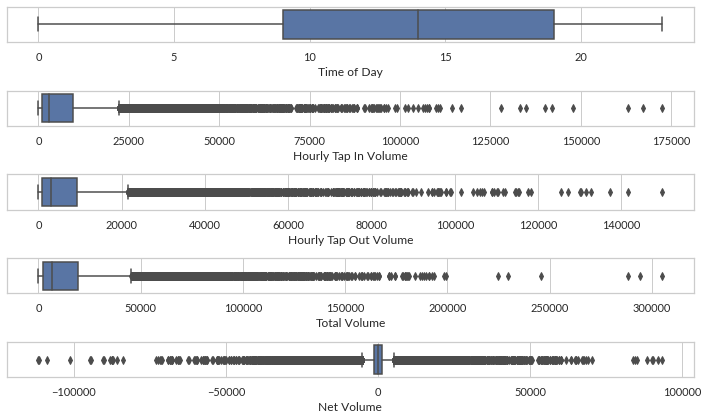

In [43]:
fig = plotAllOutliers(station_volume_df)
fig.show()
fig.savefig("./plots/outlier1.png", dpi = 200)

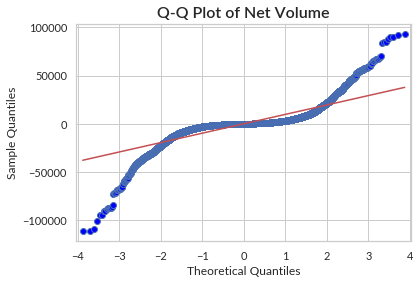

Null Hypothesis: Data Follows a Normal Distribution
Alternative Hypothesis: Data Does Not Follow a Normal Distribution

Test Results:
p-value: 0.0000
Test Statistic: 5077.9446

Reject Null Hypothesis at α = 0.05%. Data does not follow a normal distribution.


(5077.944563830573, 0.0)

In [44]:
normalityTest(station_volume_df["Net Volume"])

There are similar numbers of outliers in both tap in and out volumes. All outliers are those that are above the upper fence. We can also note that both distributions are heavily positively skewed, with the mean values being very close to the upper quartile.

This suggests passenger volumes are usually low most of the times, but there are certain periods where the passenger volume spikes up.

Total Volume also has a similar shape to tap in and out volumes, being a result of pooling together the two variables.

Net volume has a distribution that is more symmetrical (but still not normal as shown by the Q-Q plot), centered at 27. This suggests that most of the time, the proportion of people coming in and out of the station is roughly equal. However, there are instances where most people are going in, or most people are going out of the station. 

What does the distribution look like with the outliers removed?

Shape Before Removing Outliers: (18984, 9)
Shape After Removing Outliers: (14372, 9)


<ipython-input-5-bb8681b20345>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]
<ipython-input-5-bb8681b20345>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.

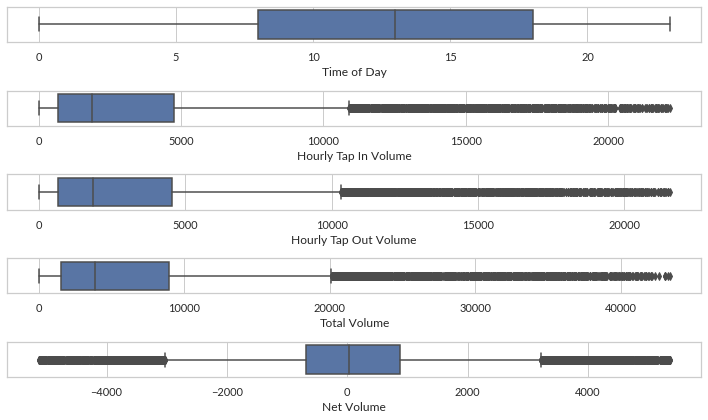

In [45]:
station_volume_no_outliers = removeOutliers(station_volume_df)
fig = plotAllOutliers(station_volume_no_outliers)
fig.show()

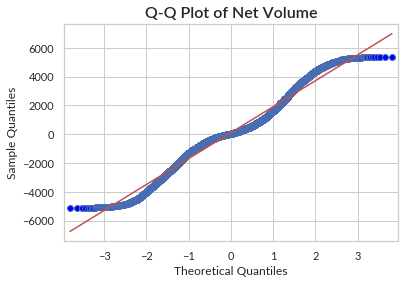

Null Hypothesis: Data Follows a Normal Distribution
Alternative Hypothesis: Data Does Not Follow a Normal Distribution

Test Results:
p-value: 0.0000
Test Statistic: 288.6501

Reject Null Hypothesis at α = 0.05%. Data does not follow a normal distribution.


(288.6500809532061, 2.0913721507673337e-63)

In [46]:
normalityTest(station_volume_no_outliers["Net Volume"])

In [47]:
station_volume_no_outliers.describe()

,Time of Day,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume
count,14372.000000,14372.000000,14372.000000,14372.000000,14372.000000
mean,13.058656,3502.462149,3390.767882,6893.230031,111.694267
std,6.240208,4211.195891,4058.511926,8072.544479,1801.500878
min,0.000000,0.000000,0.000000,1.000000,-5126.000000
25%,8.000000,659.000000,672.000000,1563.750000,-688.000000
50%,13.000000,1880.000000,1866.000000,3879.500000,32.000000
75%,18.000000,4751.750000,4534.250000,8985.500000,873.000000
max,23.000000,22166.000000,21549.000000,43366.000000,5358.000000


With the outliers removed, we note that the shape of the distributions (except net volume) remains positively skewed. However the spread of the data has been reduced as shown by a lower interquartile range and standard deviation.

The distribution of Net Volume has become significantly more normal, as shown by the Q-Q plot. However, it still does not follow a normal distribution.

We can see that the distributions of tap in and out are not significantly different from one another as the "boxes" of the box plots overlap almost completely. 

With outliers removed,
- 50% of hourly total volume ranges from 1563.75 to 8985.5

#### Will outliers be removed for later analysis?
Since the outliers actually provide information on peak demand and net movement, which are the subject of our analysis, they will not be removed.

### Data Analysis 

#### Filtering to Target Stations
For analysis, we will focus on a few target stations in the East West Line:
- Dover (EW22) : Main subject of analysis, primary way to get to SP
- Raffles Place (EW14/NS26) : Point of comparison, most going here are assumed to be office workers as it is located in the heart of the CBD area. Since it is an interchange station, we should note that not all passenger volume is from the East West Line. However, it still would roughly reflect the general commuting patterns of office workers going to the CBD via the EW line.
- Jurong East (EW24/NS1) : Point of comparison, planned to be [Singapore's next CBD](https://www.straitstimes.com/singapore/ura-puts-out-call-for-master-plan-proposals-to-develop-jurong-lake-district-billed-as). Thus it will likely see even higher demand in the future. 

#### Why compare to other stations?
- Considering the daily ridership of the MRT is on average 3.1 million as of 2016, SP students would only make up a small proportion of those using the MRT.
- Thus, the MRT would be mostly filled with non-students. Even if they do not alight at Dover MRT, they compete for capacity in the train. In addition, overcrowding can cause delays as trains have to wait longer at stations for commuters to get inside. 
- By seeing how non-students travel on the EW line, we can roughly estimate peak demand. Hence, we can provide insights as to SP students could avoid this peak demand period.

In [48]:
stations_comparison = {'EW22': 'Dover', 'EW14/NS26': 'Raffles Place', 'EW24/NS1' : 'Jurong East'}
stations_comparison_df = station_volume_df[station_volume_df["PT_CODE"].isin(stations_comparison.keys())]
stations_comparison_df["Name"] = stations_comparison_df["PT_CODE"].apply(lambda code : stations_comparison[code]) # Link code to station name for easier reading
stations_comparison_df.head()

<ipython-input-48-0d220c9eaf63>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stations_comparison_df["Name"] = stations_comparison_df["PT_CODE"].apply(lambda code : stations_comparison[code]) # Link code to station name for easier reading


,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume,Name
12,2020-10,WEEKDAY,18,TRAIN,EW24/NS1,167094,127122,294216,39972,Jurong East
13,2020-10,WEEKENDS/HOLIDAY,18,TRAIN,EW24/NS1,37152,36741,73893,411,Jurong East
16,2020-10,WEEKENDS/HOLIDAY,8,TRAIN,EW22,1491,1559,3050,-68,Dover
17,2020-10,WEEKDAY,8,TRAIN,EW22,7635,38298,45933,-30663,Dover
52,2020-10,WEEKENDS/HOLIDAY,18,TRAIN,EW22,1583,1994,3577,-411,Dover


#### Is there a relationship between the number of people tapping in and the number of people tapping out?

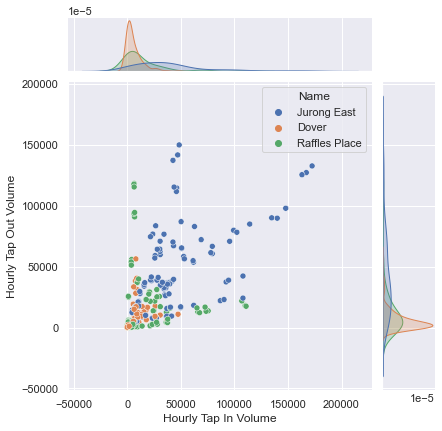

In [49]:
with sns.axes_style("darkgrid"):
    # plot = sns.pairplot(stations_comparison_df, hue="Name", kind="reg", vars=["Hourly Tap In Volume", "Hourly Tap Out Volume", "Total Volume", "Net Volume"])
    sns.jointplot(x = "Hourly Tap In Volume", y = "Hourly Tap Out Volume", data = stations_comparison_df, hue = "Name")
    # plot.map_lower(sns.kdeplot, levels = 3)
    plt.show()

#### Insights
- For Jurong East, there is a moderately positive linear relationship between hourly tap in volume and tap out volume. In addition, the spread of the distribution of tap in/out, total and net volume is the highest for Jurong East, and the distribution is also the least skewed. 
- The distribution of net volume for all three stations is centered near 0. However the higher spread for Jurong East and Raffles Place suggests that a highly positive/negative net volume is more common for those stations as compared to Dover, whose smaller spread suggests a high net volume is rarer.
- Out of the 3 stations, Jurong East tends to have the highest volume (with some hours having >200K people), followed by Raffles Place and Dover.

#### How does the distribution of total passenger volume differ by station?

<ipython-input-50-1762da5d6168>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


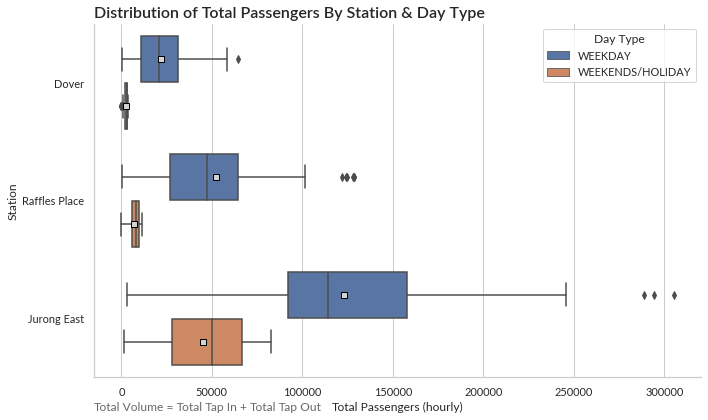

In [50]:
# Plotting
fig, ax = plt.subplots(figsize = (10, 6), tight_layout = True)
sns.boxplot(x = "Total Volume", y ="Name", hue="Day Type", data = stations_comparison_df, ax = ax, showmeans = True, meanprops = { "markerfacecolor" : "lightgray", "markeredgecolor" : "black", "marker" : "s"}, order = ["Dover", "Raffles Place", "Jurong East"]) # show mean alongside median as light gray square marker, order box plots by ascending order 

# Annotation & Visuals
ax.set_xlabel("Total Passengers (hourly)")
ax.set_ylabel("Station")
ax.set_title("Distribution of Total Passengers By Station & Day Type", loc = "left", weight="semibold", fontsize = 16) # set title, and align it to top left, with larger font size and weight
ax.text(-15000, 2.78, "Total Volume = Total Tap In + Total Tap Out", color = "dimgray") # provide definition of total volume in fine print for reader
sns.despine(right = True) # remove spine from plot
fig.show()
fig.savefig("./plots/mrt_boxplot.png", dpi = 200) # save plot with higher resolution 

In [51]:
stations_comparison_df.pivot_table(values="Total Volume", index=["Name", "Day Type"], aggfunc=[min, max, np.mean, np.median, np.std]) # Produce a pivot table containing summary statistics

min          max           mean  \
                               Total Volume Total Volume   Total Volume   
Name          Day Type                                                    
Dover         WEEKDAY                   184        64387   21686.333333   
              WEEKENDS/HOLIDAY           61         3884    2566.100000   
Jurong East   WEEKDAY                  3029       305091  122921.366667   
              WEEKENDS/HOLIDAY         1543        82823   44938.266667   
Raffles Place WEEKDAY                   314       128788   52412.183333   
              WEEKENDS/HOLIDAY           76        11297    7214.516667   

                                     median           std  
                               Total Volume  Total Volume  
Name          Day Type                                     
Dover         WEEKDAY               20949.0  15024.829664  
              WEEKENDS/HOLIDAY       3016.5   1135.874481  
Jurong East   WEEKDAY              114382.5  69758.016775  
              WEEKENDS/HOLIDAY      50275.5  24409.988008  
Raffles Place WEEKDAY               47431.0  35275.580079  
              WEEKENDS/HOLIDAY       8062.5   3322.507066

#### Insights
- For both Weekdays and Weekends, Jurong East has the highest median total volume of 114382.5 and 44938.266667	respectively. In fact, the median passenger volume for Jurong East on a Weekday is around 5 times that of Dover MRT and around 2 times that of Raffles Place.
- The high demand for Jurong East can be explained by it's status as a regional center. It is connected to two malls (JEM and Westgate), contains a bus interchange, connects to two major MRT lines (North-South and East-West) and is located various business parks. This can also explain why out of the three stations, it has the highest demand in the Weekends: the presence of amenities like Shopping Malls keeps demand high.

How does the peak demand differ by MRT Station?

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-52-a038a6a96b67>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


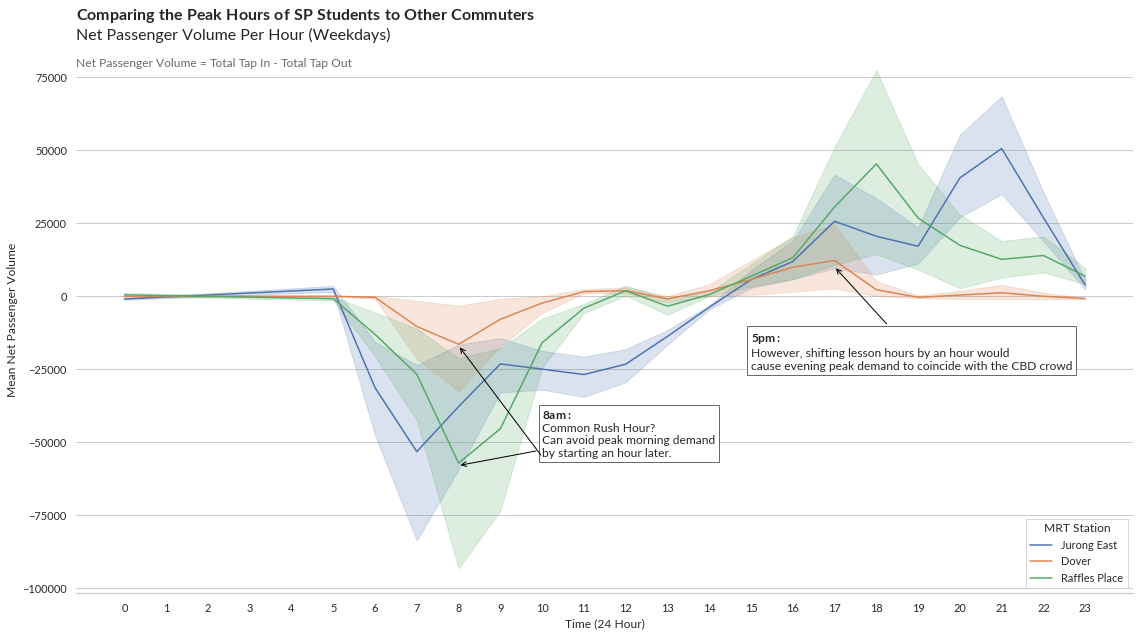

In [52]:
fig, ax = plt.subplots(figsize = (16, 9), tight_layout = True)
sns.lineplot("Time of Day", "Net Volume", "Name", data = stations_comparison_df, ax = ax)

ax.set_title(r"$\bf{Comparing\ the\ Peak\ Hours\ of\ SP\ Students\ to\ Other\ Commuters}$" + "\nNet Passenger Volume Per Hour (Weekdays)", loc = "left", fontsize = 16)
ax.grid(False, axis = "x") # remove vertical grid lines
ax.set_xticks(np.arange(24)) # make tick every hour
ax.set_xlabel("Time (24 Hour)")
ax.set_ylabel("Mean Net Passenger Volume")
ax.legend(title = "MRT Station", fancybox = False, loc="lower right")

# Annotations
bbox = {
    "boxstyle" : "square,pad=0.3",
    "fc" : "white",
    "ec" : "dimgrey"
}
ax.text(-1.15, 78500, "Net Passenger Volume = Total Tap In - Total Tap Out", color = "dimgray")
ax.annotate(r"$\bf{8am:}$" + "\nCommon Rush Hour?\nCan avoid peak morning demand\nby starting an hour later.", (8, -58000), (10, -55000), arrowprops = { "arrowstyle" : "->", "color" : "black"}, bbox = bbox)
ax.annotate("", (8, -17000), (10, -55000), arrowprops = { "arrowstyle" : "->", "color" : "black"})
ax.annotate(r"$\bf{5pm:}$" + "\nHowever, shifting lesson hours by an hour would\ncause evening peak demand to coincide with the CBD crowd", (17, 10000), (15, -25000), arrowprops = { "arrowstyle" : "->", "color" : "black"}, bbox = bbox)
sns.despine(left = True)
fig.show()

In [53]:
fig.savefig("./plots/net_passenger_volume_mrt.png", dpi = 200)

#### Insights
- Net volume follows a “valley and hill” shape, where in the morning, most movement is out of the stations, and in the afternoon/evening, most movement is into the stations (going home). 
Peak net volume for Jurong East (7am)  and Raffles Place (8am) is more than 50k each, which is more than twice the peak net volume for Dover MRT (8am). 
- Most people arrive at Dover from 8:00am to 8:59am, and leave at 4:00pm to 4:59pm. This likely reflects typical class scheduling with most lessons starting around 8 to 10am.
- The peak demand hours for Dover (8am and 4pm) coincide with Raffles Place (8am) in the morning and are just before Raffles Place (5am) in the evening. To escape the morning rush hour, would need to start more lessons later, but lessons would have to end at around 7 (to escape evening rush hour for Raffles). 


### Dataset 3: PASSENGER VOLUME BY BUS STOPS

### Loading the Data

In [54]:
bus_volume_df = get_transport_data_zip("http://datamall2.mytransport.sg/ltaodataservice/PV/Bus", dates, "busstop_volume", LTA_API_KEY, True) # get data
bus_volume_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2020-10,WEEKENDS/HOLIDAY,17,BUS,45379,148,82
1,2020-10,WEEKDAY,17,BUS,45379,443,294
2,2020-10,WEEKENDS/HOLIDAY,13,BUS,80051,1201,1144
3,2020-10,WEEKDAY,13,BUS,80051,2382,2754
4,2020-10,WEEKDAY,13,BUS,5319,78,317


In [55]:
bus_volume_df.rename(columns = {
    "YEAR_MONTH" : "Year-Month",
    "DAY_TYPE" : "Day Type",
    "TIME_PER_HOUR" : "Time of Day",
    "PT_TYPE" : "Mode of Travel",
    "TOTAL_TAP_IN_VOLUME" : "Hourly Tap In Volume",
    "TOTAL_TAP_OUT_VOLUME" : "Hourly Tap Out Volume"
}, inplace = True)

In [56]:
bus_volume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580862 entries, 0 to 580861
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Year-Month             580862 non-null  object
 1   Day Type               580862 non-null  object
 2   Time of Day            580862 non-null  int64 
 3   Mode of Travel         580862 non-null  object
 4   PT_CODE                580862 non-null  int64 
 5   Hourly Tap In Volume   580862 non-null  int64 
 6   Hourly Tap Out Volume  580862 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 31.0+ MB


### Checking for Null Values

In [57]:
bus_volume_df.isna().sum()

Year-Month               0
Day Type                 0
Time of Day              0
Mode of Travel           0
PT_CODE                  0
Hourly Tap In Volume     0
Hourly Tap Out Volume    0
dtype: int64

### Generating Summary Statistics 

In [58]:
bus_volume_df.describe(include='all')

,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume
count,580862,580862,580862.000000,580862,580862.000000,580862.000000,580862.000000
unique,3,2,NaN,1,NaN,NaN,NaN
top,2020-12,WEEKDAY,NaN,BUS,NaN,NaN,NaN
freq,194409,293337,NaN,580862,NaN,NaN,NaN
mean,NaN,NaN,13.315412,NaN,48777.359948,453.011736,453.008901
std,NaN,NaN,6.105520,NaN,25466.697828,1578.477199,1501.728528
min,NaN,NaN,0.000000,NaN,1012.000000,0.000000,0.000000
25%,NaN,NaN,9.000000,NaN,25359.000000,23.000000,25.000000
50%,NaN,NaN,14.000000,NaN,49159.000000,118.000000,126.000000
75%,NaN,NaN,18.000000,NaN,67089.000000,407.000000,412.000000


Just as with the MRT volume dataset, the tap in volume appears to be heavily positively skewed as the upper quartile of tap in/out volume is much lower than the maximum value.

### Data Preprocessing

- Just as with the previous dataset, we will create a Total & Net Volume column

In [59]:
bus_volume_df["Total Volume"] = bus_volume_df["Hourly Tap In Volume"] + bus_volume_df["Hourly Tap Out Volume"]

bus_volume_df["Net Volume"] = bus_volume_df["Hourly Tap In Volume"] - bus_volume_df["Hourly Tap Out Volume"]

bus_volume_df.describe()

,Time of Day,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume
count,580862.000000,580862.000000,580862.000000,580862.000000,580862.000000,580862.000000
mean,13.315412,48777.359948,453.011736,453.008901,906.020637,0.002835
std,6.105520,25466.697828,1578.477199,1501.728528,2929.572674,954.547866
min,0.000000,1012.000000,0.000000,0.000000,1.000000,-48961.000000
25%,9.000000,25359.000000,23.000000,25.000000,68.000000,-87.000000
50%,14.000000,49159.000000,118.000000,126.000000,287.000000,-1.000000
75%,18.000000,67089.000000,407.000000,412.000000,859.000000,80.000000
max,23.000000,99189.000000,122459.000000,100153.000000,216027.000000,50318.000000


### Checking for Outliers

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel  PT_CODE  \
2     2020-10  WEEKENDS/HOLIDAY           13            BUS    80051   
3     2020-10           WEEKDAY           13            BUS    80051   
10    2020-10  WEEKENDS/HOLIDAY           20            BUS    46009   
11    2020-10           WEEKDAY           20            BUS    46009   
13    2020-10           WEEKDAY           12            BUS    19081   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
2                   1201                   1144          2345          57  
3                   2382                   2754          5136        -372  
10                 20548                  11624         32172        8924  
11                 54831                  28776         83607       26055  
13                  3662                    597          4259        3065  
No. of Outliers: 61959


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


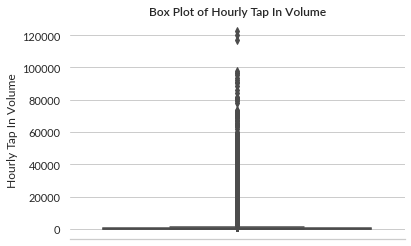

In [60]:
tap_in_outliers = outlierDetection(bus_volume_df, "Hourly Tap In Volume")

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel  PT_CODE  \
2     2020-10  WEEKENDS/HOLIDAY           13            BUS    80051   
3     2020-10           WEEKDAY           13            BUS    80051   
10    2020-10  WEEKENDS/HOLIDAY           20            BUS    46009   
11    2020-10           WEEKDAY           20            BUS    46009   
48    2020-10           WEEKDAY           14            BUS    84119   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
2                   1201                   1144          2345          57  
3                   2382                   2754          5136        -372  
10                 20548                  11624         32172        8924  
11                 54831                  28776         83607       26055  
48                  2196                   1704          3900         492  
No. of Outliers: 60197


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


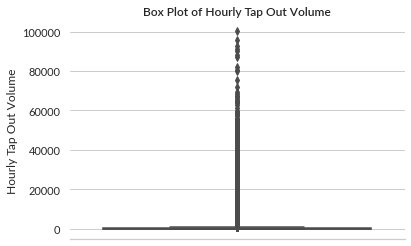

In [61]:
tap_out_outliers = outlierDetection(bus_volume_df, "Hourly Tap Out Volume")

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel  PT_CODE  \
2     2020-10  WEEKENDS/HOLIDAY           13            BUS    80051   
3     2020-10           WEEKDAY           13            BUS    80051   
10    2020-10  WEEKENDS/HOLIDAY           20            BUS    46009   
11    2020-10           WEEKDAY           20            BUS    46009   
13    2020-10           WEEKDAY           12            BUS    19081   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
2                   1201                   1144          2345          57  
3                   2382                   2754          5136        -372  
10                 20548                  11624         32172        8924  
11                 54831                  28776         83607       26055  
13                  3662                    597          4259        3065  
No. of Outliers: 58010


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


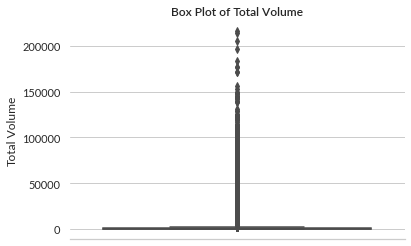

In [62]:
total_vol_outliers = outlierDetection(bus_volume_df, "Total Volume")

Compared to the MRT, the distribution of tap ins and out is even more heavily skewed. 

Outliers in Series (First 5)
   Year-Month          Day Type  Time of Day Mode of Travel  PT_CODE  \
3     2020-10           WEEKDAY           13            BUS    80051   
6     2020-10           WEEKDAY            6            BUS    42029   
10    2020-10  WEEKENDS/HOLIDAY           20            BUS    46009   
11    2020-10           WEEKDAY           20            BUS    46009   
13    2020-10           WEEKDAY           12            BUS    19081   

    Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  
3                   2382                   2754          5136        -372  
6                    199                    696           895        -497  
10                 20548                  11624         32172        8924  
11                 54831                  28776         83607       26055  
13                  3662                    597          4259        3065  
No. of Outliers: 125543


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


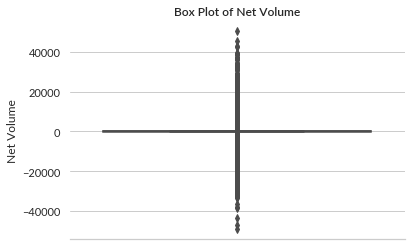

In [63]:
net_vol_outliers = outlierDetection(bus_volume_df, "Net Volume")

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\li

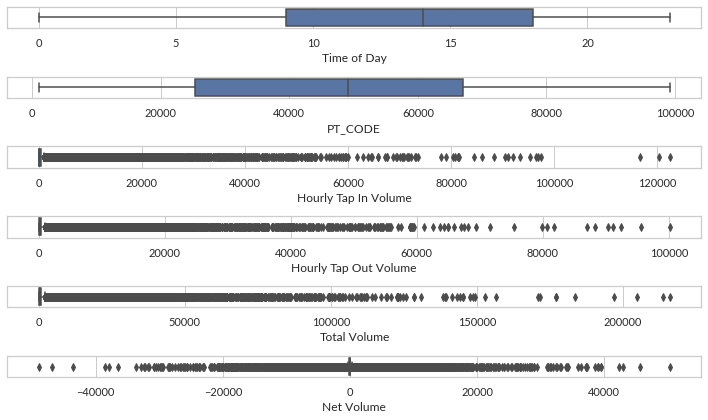

In [64]:
fig = plotAllOutliers(bus_volume_df)
fig.show()
fig.savefig("./plots/outlier2.png", dpi = 200)

We can observe that the data contains many outliers. The tap in/out/total volumes have outliers much higher than the upper fence. (Magnitudes of over 200K per hour). 

In [65]:
total_vol_outliers.groupby("PT_CODE")["Total Volume"].max().sort_values(ascending = False)

PT_CODE
22009    216027
46009    149461
75009    145223
28009    103973
52009     99405
          ...  
52099      2052
51081      2050
43199      2049
44069      2047
77311      2046
Name: Total Volume, Length: 2147, dtype: int64

It appears that many of these outliers in the 100K and above range are bus interchanges. This would explain the unusually high passenger volumes as they house many bus services. Other outliers appear to be facilities like Schools and Healthcare Organisations which would see more traffic than typical residential areas.

- 22009 :  Boon Lay Interchange (216027)
- 46009 : Woodlands Temp Interchange (149461)
- 52099 :     Opp NKF (2052)
- 77311 : Near Meridian Primary School (2046)

Shape Before Removing Outliers: (580862, 9)


<ipython-input-5-bb8681b20345>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]
<ipython-input-5-bb8681b20345>:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data = data[~((data < (Q1 - (1.5 * IQR))) | (data > (Q3 + (1.5 * IQR)))).any(axis=1)]


Shape After Removing Outliers: (441565, 9)


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\li

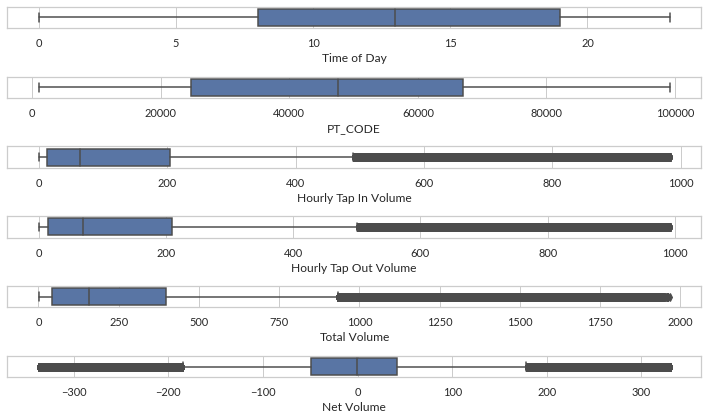

In [66]:
station_bus_no_outliers = removeOutliers(bus_volume_df)
fig = plotAllOutliers(station_bus_no_outliers)
fig.show()

In [67]:
station_bus_no_outliers.describe()

,Time of Day,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume
count,441565.000000,441565.000000,441565.000000,441565.000000,441565.000000,441565.000000
mean,13.154754,48403.951907,141.477209,144.573904,286.051114,-3.096695
std,6.352054,25595.343883,181.556574,181.731699,344.576345,115.089279
min,0.000000,1012.000000,0.000000,0.000000,1.000000,-337.000000
25%,8.000000,24719.000000,13.000000,14.000000,41.000000,-49.000000
50%,13.000000,47651.000000,65.000000,70.000000,157.000000,-1.000000
75%,19.000000,67061.000000,204.000000,209.000000,398.000000,42.000000
max,23.000000,99189.000000,983.000000,992.000000,1967.000000,330.000000


Once these outliers are removed, the shape of the distributions becomes clearer. We can see that the data is positively skewed, with most bus stops having an hourly volume of 41 to 398 people entering and leaving.

Since we are only concerned about the bus stops servicing SP, we will filter down to those bus stops only first.

In [68]:
bus_comparison = { 19039 : "Dover Bus Stop"}
bus_comparison_df = bus_volume_df[bus_volume_df["PT_CODE"].isin(bus_comparison.keys())]
bus_comparison_df["Name"] = bus_comparison_df["PT_CODE"].apply(lambda code : bus_comparison[code])
bus_comparison_df.head()

<ipython-input-68-b49eaa6e5e88>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bus_comparison_df["Name"] = bus_comparison_df["PT_CODE"].apply(lambda code : bus_comparison[code])


,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume,Name
8848,2020-10,WEEKDAY,8,BUS,19039,4265,5642,9907,-1377,Dover Bus Stop
8849,2020-10,WEEKENDS/HOLIDAY,8,BUS,19039,896,642,1538,254,Dover Bus Stop
28888,2020-10,WEEKDAY,20,BUS,19039,2674,594,3268,2080,Dover Bus Stop
28889,2020-10,WEEKENDS/HOLIDAY,20,BUS,19039,1064,215,1279,849,Dover Bus Stop
34728,2020-10,WEEKENDS/HOLIDAY,22,BUS,19039,743,151,894,592,Dover Bus Stop


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\li

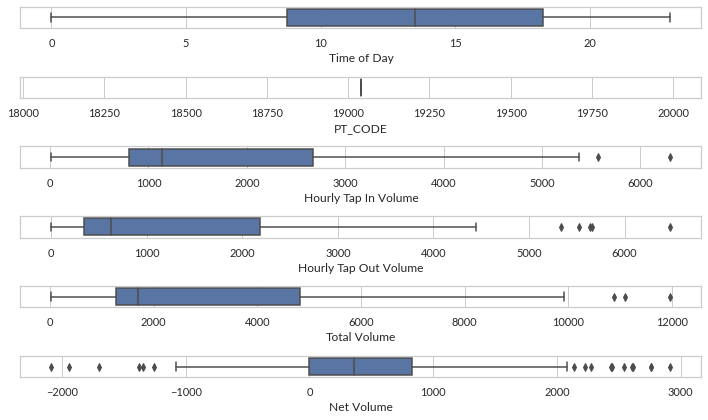

In [69]:
fig = plotAllOutliers(bus_comparison_df)
fig.show()
fig.savefig("./plots/outlier3.png", dpi = 200)

When filtered down, we note that the subset of data appears to be more positively skewed than the overall dataset.

Outliers in Series (First 5)
       Year-Month Day Type  Time of Day Mode of Travel  PT_CODE  \
117470    2020-10  WEEKDAY            7            BUS    19039   
201740    2020-11  WEEKDAY            8            BUS    19039   
310698    2020-11  WEEKDAY            7            BUS    19039   

        Hourly Tap In Volume  Hourly Tap Out Volume  Total Volume  Net Volume  \
117470                  6304                   5663         11967         641   
201740                  4395                   6479         10874       -2084   
310698                  5570                   5526         11096          44   

                  Name  
117470  Dover Bus Stop  
201740  Dover Bus Stop  
310698  Dover Bus Stop  
No. of Outliers: 3


C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


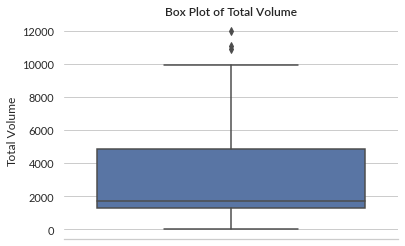

In [70]:
total_vol_outliers = outlierDetection(bus_comparison_df, "Total Volume")

<AxesSubplot:xlabel='Time of Day'>

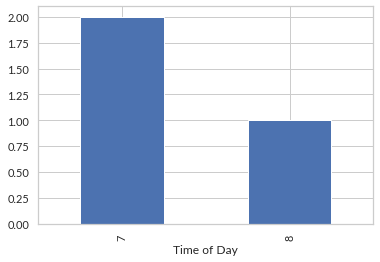

In [71]:
total_vol_outliers.groupby("Time of Day").size().plot(kind="bar")

In [72]:
total_vol_outliers.groupby("Name").size()

Name
Dover Bus Stop    3
dtype: int64

In [73]:
total_vol_outliers.groupby("Name").mean()

,Time of Day,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume
Name,,,,,,
Dover Bus Stop,7.333333,19039.0,5423.0,5889.333333,11312.333333,-466.333333


All outliers in the subset come from Dover MRT Bus Stop.

### Merging with MRT Volume Dataset

In [74]:
busmrt_volume = pd.concat([stations_comparison_df, bus_comparison_df], ignore_index= True)
busmrt_volume.head()

,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume,Name
0,2020-10,WEEKDAY,18,TRAIN,EW24/NS1,167094,127122,294216,39972,Jurong East
1,2020-10,WEEKENDS/HOLIDAY,18,TRAIN,EW24/NS1,37152,36741,73893,411,Jurong East
2,2020-10,WEEKENDS/HOLIDAY,8,TRAIN,EW22,1491,1559,3050,-68,Dover
3,2020-10,WEEKDAY,8,TRAIN,EW22,7635,38298,45933,-30663,Dover
4,2020-10,WEEKENDS/HOLIDAY,18,TRAIN,EW22,1583,1994,3577,-411,Dover


In [75]:
busmrt_volume["PT_CODE"].unique()

array(['EW24/NS1', 'EW22', 'EW14/NS26', 19039], dtype=object)

### Final Output 1: Bus MRT Volume

In [76]:
busmrt_volume.to_csv("./output/busmrt_volume.csv")

### Data Analysis

<ipython-input-77-6850ebc6d348>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_only["Time Interval"] = pd.cut(sp_only["Time of Day"], [5,12,18,24], # Morn: 5 to 12, Afternoon: 12 to 6, Evening: 6 to midnight


<AxesSubplot:xlabel='Time Interval', ylabel='Total Volume'>

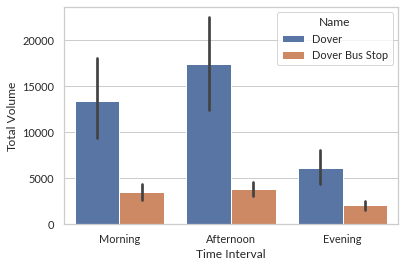

In [77]:
sp_only = busmrt_volume[busmrt_volume["PT_CODE"].isin(["EW22", 19039])]
sp_only["Time Interval"] = pd.cut(sp_only["Time of Day"], [5,12,18,24], # Morn: 5 to 12, Afternoon: 12 to 6, Evening: 6 to midnight
                            labels=["Morning", "Afternoon", "Evening"], include_lowest= True)
sns.barplot(data = sp_only, x = "Time Interval", y = "Total Volume", hue="Name")

#### Do Hourly Tap Ins Correlate With Tap Outs?

In [78]:
group_by = sp_only.groupby(["Day Type", "Mode of Travel"])[["Hourly Tap In Volume", "Hourly Tap Out Volume"]]
group_by.corr()

Hourly Tap In Volume  \
Day Type         Mode of Travel                                               
WEEKDAY          BUS            Hourly Tap In Volume               1.000000   
                                Hourly Tap Out Volume              0.622857   
                 TRAIN          Hourly Tap In Volume               1.000000   
                                Hourly Tap Out Volume              0.114845   
WEEKENDS/HOLIDAY BUS            Hourly Tap In Volume               1.000000   
                                Hourly Tap Out Volume              0.512281   
                 TRAIN          Hourly Tap In Volume               1.000000   
                                Hourly Tap Out Volume              0.572894   

                                                       Hourly Tap Out Volume  
Day Type         Mode of Travel                                               
WEEKDAY          BUS            Hourly Tap In Volume                0.622857  
                                Hourly Tap Out Volume               1.000000  
                 TRAIN          Hourly Tap In Volume                0.114845  
                                Hourly Tap Out Volume               1.000000  
WEEKENDS/HOLIDAY BUS            Hourly Tap In Volume                0.512281  
                                Hourly Tap Out Volume               1.000000  
                 TRAIN          Hourly Tap In Volume                0.572894  
                                Hourly Tap Out Volume               1.000000

In [79]:
group_by.min()

Hourly Tap In Volume  Hourly Tap Out Volume
Day Type         Mode of Travel                                             
WEEKDAY          BUS                               58                      7
                 TRAIN                              8                    174
WEEKENDS/HOLIDAY BUS                               14                      3
                 TRAIN                              5                     28

In [80]:
group_by.max()

Hourly Tap In Volume  Hourly Tap Out Volume
Day Type         Mode of Travel                                             
WEEKDAY          BUS                             6304                   6479
                 TRAIN                          47465                  56305
WEEKENDS/HOLIDAY BUS                             1243                    815
                 TRAIN                           2186                   2180

<ipython-input-81-99fdf91a111e>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  lm_grid.fig.show()


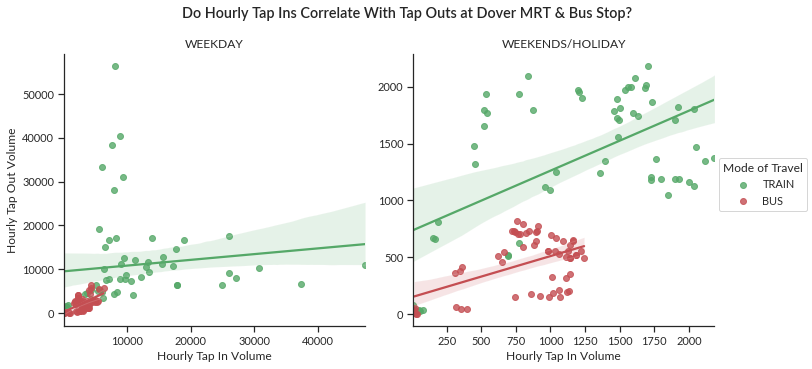

In [81]:
with sns.axes_style("ticks", { "font.family" : "Lato"}):
    lm_grid = sns.lmplot(x = "Hourly Tap In Volume", y = "Hourly Tap Out Volume", data = sp_only, hue="Mode of Travel", col="Day Type", sharex = False, sharey= False, palette=["g", "r"], col_order = ["WEEKDAY", "WEEKENDS/HOLIDAY"]) # plot multiple regression lines, 
    lm_grid.fig.suptitle("Do Hourly Tap Ins Correlate With Tap Outs at Dover MRT & Bus Stop?", weight = "semibold")
    lm_grid.fig.subplots_adjust(top = 0.85) # adjust position of title to not overlap with graph
    lm_grid.set_titles(col_template ="{col_name}")
    lm_grid.legend.set_frame_on(True)
    lm_grid.fig.show()
lm_grid.fig.savefig("./plots/scatter_mrtbus.png", dpi = 200)

#### Insights
- On Weekdays, there is a moderate positive relationship between Tap in and Tap out for the Dover Bus Stop (R = 0.622857), while the relationship between tap in and tap outs for Dover MRT is weak (R = 0.114845). 
- On Weekends/Holidays, this changes as for both MRT and Bus there is a moderate positive relationship between hourly tap ins and tap out volume (R = 0.572894 (MRT) and R = 0.512281 (Bus)) respectively. This is likely because the main population using the MRT station has changed from mostly students to mostly the general public. 
- On a weekday, tap in and tap out volumes for Dover Bus Stop are concentrated in the range 60 to 7000. Tap in and tap out volumes for Dover MRT are more spread out with a greater range of 10 to 60000. 

In [82]:
demand_df =pd.crosstab(index = sp_only["Year-Month"], columns=sp_only["Time Interval"], values = sp_only["Total Volume"], aggfunc= np.mean)

<ipython-input-83-f0093b8a9e8e>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


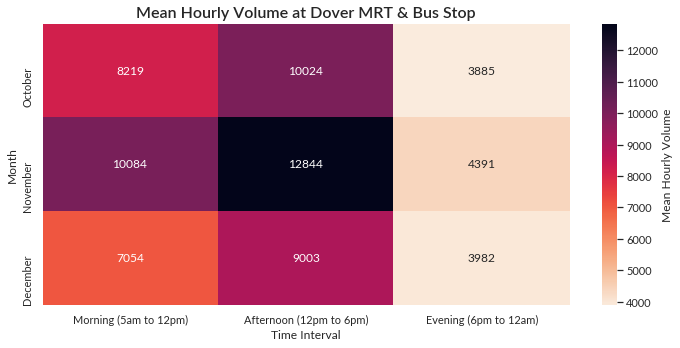

In [83]:
# [5,12,19,24]
fig, ax = plt.subplots(figsize=(10, 5), tight_layout = True)
sns.heatmap(demand_df, ax= ax, cmap="rocket_r", annot = True, fmt = ".0f", yticklabels = ["October" , "November", "December"], cbar_kws = {
    "orientation": "vertical",
    "label" : "Mean Hourly Volume"
}, xticklabels = ["Morning (5am to 12pm)", "Afternoon (12pm to 6pm)", "Evening (6pm to 12am)"])
ax.set_title("Mean Hourly Volume at Dover MRT & Bus Stop", weight = "semibold", fontsize = 16)
ax.set_ylabel("Month")
fig.show()
fig.savefig("./plots/heatmap_volume.png", dpi = 200)

#### Insights
- Greatest demand in November across all time intervals (mean hourly volume of 10084 in morning is 1865 more than in October). Based on the SP academic calendar, this is during Term 3 (start of Sem 2).
- Lowest demand during December is likely due to there being an ongoing term vacation during that time which lasts until January. However, even with a vacation the mean hourly volume in the morning and afternoon is still relatively high. 
- Generally, the highest mean hourly volume occurs during the Afternoon Period (12pm to 6pm).

## Objective 3: Is there a need to adjust bus frequencies for buses serving SP?

### Dataset 4: Bus Arrival Data
- Compiled real time bus arrival data for bus stops near SP (Dover MRT and Alongside Commonwealth Ave)
- Data queried from API every 30 minutes

### Loading the Data

In [84]:
data = [pd.read_csv("./bus_arrival/" + filename, index_col= 0) for filename in os.listdir("./bus_arrival")]
bus_arrival_df = pd.concat(data, ignore_index= True)
bus_arrival_df = bus_arrival_df[bus_arrival_df["Bus Stop Code"] == 19039] # filter to only Dover MRT Bus Stop

In [85]:
bus_arrival_df.describe(include='all')

,ServiceNo,Operator,NextBus.OriginCode,NextBus.DestinationCode,NextBus.EstimatedArrival,NextBus.Latitude,NextBus.Longitude,NextBus.VisitNumber,NextBus.Load,NextBus.Feature,...,NextBus3.DestinationCode,NextBus3.EstimatedArrival,NextBus3.Latitude,NextBus3.Longitude,NextBus3.VisitNumber,NextBus3.Load,NextBus3.Feature,NextBus3.Type,Timestamp,Bus Stop Code
count,1404.0,1404,1404.000000,1404.000000,1404,1404.000000,1404.000000,1404.0,1404,1404,...,1292.000000,1292,1292.000000,1292.000000,1292.0,1292,1292,1292,1404,1404.0
unique,15.0,2,NaN,NaN,1391,NaN,NaN,NaN,2,1,...,NaN,1292,NaN,NaN,NaN,2,1,2,212,1.0
top,74.0,SBST,NaN,NaN,2021-02-06T13:33:50+08:00,NaN,NaN,NaN,SEA,WAB,...,NaN,2021-02-06T11:05:44+08:00,NaN,NaN,NaN,SEA,WAB,DD,2021-02-08 08:04:00+08:00,19039.0
freq,185.0,1209,NaN,NaN,3,NaN,NaN,NaN,1352,1404,...,NaN,1,NaN,NaN,NaN,1263,1292,781,8,1404.0
mean,NaN,NaN,30155.410256,41805.356838,NaN,1.084600,85.365102,1.0,NaN,NaN,...,42162.604489,NaN,0.497038,38.390172,1.0,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,16629.909454,30087.031464,NaN,0.503847,39.650053,0.0,NaN,NaN,...,30071.484280,NaN,0.648901,50.117169,0.0,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,17009.000000,3218.000000,NaN,0.000000,0.000000,1.0,NaN,NaN,...,3218.000000,NaN,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,17009.000000,11379.000000,NaN,1.311951,103.759497,1.0,NaN,NaN,...,11379.000000,NaN,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,22609.000000,54009.000000,NaN,1.312517,103.766161,1.0,NaN,NaN,...,54009.000000,NaN,0.000000,0.000000,1.0,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,43009.000000,66009.000000,NaN,1.319282,103.771934,1.0,NaN,NaN,...,66009.000000,NaN,1.338209,103.732473,1.0,NaN,NaN,NaN,NaN,NaN


In [86]:
bus_arrival_df["ServiceNo"].unique()

array([105, 106, 14, 147, 166, 185, 74, '105', '106', '14', '147', '166',
       '185', '74', '74e'], dtype=object)

In [87]:
bus_arrival_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1404 entries, 0 to 2783
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ServiceNo                  1404 non-null   object 
 1   Operator                   1404 non-null   object 
 2   NextBus.OriginCode         1404 non-null   float64
 3   NextBus.DestinationCode    1404 non-null   float64
 4   NextBus.EstimatedArrival   1404 non-null   object 
 5   NextBus.Latitude           1404 non-null   float64
 6   NextBus.Longitude          1404 non-null   float64
 7   NextBus.VisitNumber        1404 non-null   float64
 8   NextBus.Load               1404 non-null   object 
 9   NextBus.Feature            1404 non-null   object 
 10  NextBus.Type               1404 non-null   object 
 11  NextBus2.OriginCode        1355 non-null   float64
 12  NextBus2.DestinationCode   1355 non-null   float64
 13  NextBus2.EstimatedArrival  1355 non-null   objec

ServiceNo is an object because certain bus services have alphabets in their names. For some reason, there are duplicate service numbers which will need to be fixed.

[Bus Service No Suffix/Prefix Explained](https://landtransportguru.net/bus-service-prefixes-and-suffixes/)

Timestamp, and Estimated Arrival data is of the wrong data type. It should be a Timestamp.

We will drop unnecessary columns like origin/destination code, lat, lng

In [88]:
bus_arrival_df["ServiceNo"] = bus_arrival_df["ServiceNo"].astype(str)
bus_arrival_df["ServiceNo"].unique()

array(['105', '106', '14', '147', '166', '185', '74', '74e'], dtype=object)

In [89]:
code_cols = bus_arrival_df.columns[list(map(lambda x : x.endswith("Code"), bus_arrival_df.columns))].tolist()
lat_cols = bus_arrival_df.columns[list(map(lambda x : x.endswith("Latitude"), bus_arrival_df.columns))].tolist()
lng_cols = bus_arrival_df.columns[list(map(lambda x : x.endswith("Longitude"), bus_arrival_df.columns))].tolist()
bus_arrival_df.drop(code_cols + lat_cols + lng_cols, axis = 1, inplace = True)

In [90]:
print("Before:\n", bus_arrival_df["Timestamp"].head())
bus_arrival_df["Timestamp"] = bus_arrival_df["Timestamp"].astype("datetime64").dt.tz_localize("UTC").dt.tz_convert("Asia/Singapore")
print("After:\n", bus_arrival_df["Timestamp"].head())

Before:
 0    2021-02-05 21:00:00+08:00
1    2021-02-05 21:00:00+08:00
2    2021-02-05 21:00:00+08:00
3    2021-02-05 21:00:00+08:00
4    2021-02-05 21:00:00+08:00
Name: Timestamp, dtype: object
After:
 0   2021-02-05 21:00:00+08:00
1   2021-02-05 21:00:00+08:00
2   2021-02-05 21:00:00+08:00
3   2021-02-05 21:00:00+08:00
4   2021-02-05 21:00:00+08:00
Name: Timestamp, dtype: datetime64[ns, Asia/Singapore]


In [91]:
# Testing that time conversion was done correctly
test = "2021-02-14 11:09:00+08:00"
series = pd.Series([test]).astype("datetime64").dt.tz_localize("UTC").dt.tz_convert("Asia/Singapore")
assert series.iloc[0].hour == 11

In [92]:
arrival_cols = bus_arrival_df.columns[list(map(lambda x : x.endswith("EstimatedArrival"), bus_arrival_df.columns))]
bus_arrival_df[arrival_cols] = bus_arrival_df[arrival_cols].transform(lambda x : x.astype("datetime64").dt.tz_localize("UTC").dt.tz_convert("Asia/Singapore"))
bus_arrival_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1404 entries, 0 to 2783
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype                         
---  ------                     --------------  -----                         
 0   ServiceNo                  1404 non-null   object                        
 1   Operator                   1404 non-null   object                        
 2   NextBus.EstimatedArrival   1404 non-null   datetime64[ns, Asia/Singapore]
 3   NextBus.VisitNumber        1404 non-null   float64                       
 4   NextBus.Load               1404 non-null   object                        
 5   NextBus.Feature            1404 non-null   object                        
 6   NextBus.Type               1404 non-null   object                        
 7   NextBus2.EstimatedArrival  1355 non-null   datetime64[ns, Asia/Singapore]
 8   NextBus2.VisitNumber       1355 non-null   float64                       
 9   NextBus2.Load      

### Extracting Features
To extract more useful insights, we will perform additional data wrangling

- Time of Day: Hour of the Day in which Data was Obtained
- Day of Week: Day of the Week in which data was obtained
- Mean Bus Frequency: Defined as $\overline{Bus Freq} = \frac{1}{N - 1}\sum_{i=2}^N(Estimated\ Arrival\ Time\ for\ Bus\ i - Estimated\ Arrival\ Time\ for\ Bus\ (i - 1))\ where\ N = Number\ of\ Buses\ Ahead$. This method was chosen as other info on bus frequency on LTA Datamall only provides frequency for pre defined periods of times, which may not match up with the period of peak demand in SP. According to LTA, [estimated arrival timings should be within 3 minutes of arrival time](https://www.straitstimes.com/singapore/transport/lta-bus-arrival-times-more-accurate-now). However, it may not be fully representative of actual frequency of dispatch as there may be some sampling bias due to the way the bus arrival data was collected. It is hoped that averaged over several days, our mean bus frequency would be a close enough approximation of the actual frequency to allow for some analysis. 

In [93]:
bus_arrival_df["Time of Day"] = bus_arrival_df["Timestamp"].dt.hour
bus_arrival_df[["Timestamp", "Time of Day"]].sample(3)

,Timestamp,Time of Day
855,2021-02-07 16:03:00+08:00,16
539,2021-02-06 23:32:00+08:00,23
631,2021-02-07 08:03:00+08:00,8


In [94]:
bus_arrival_df["Day of Week"] = bus_arrival_df["Timestamp"].dt.day_name()
bus_arrival_df[["Timestamp", "Day of Week"]].sample(3)

,Timestamp,Day of Week
1718,2021-02-09 09:04:00+08:00,Tuesday
2155,2021-02-10 05:35:00+08:00,Wednesday
713,2021-02-07 11:03:00+08:00,Sunday


In [95]:
bus_arrival_df["Mean Bus Frequency (seconds)"] = bus_arrival_df[arrival_cols].diff(periods = 1, axis = 1).apply(lambda x : x.dt.seconds).mean(axis = 1) # get difference between estimated arrival timings, and then get the mean of the estimated arrival timing
bus_arrival_df[["Timestamp", "Mean Bus Frequency (seconds)"]].sample(3)

,Timestamp,Mean Bus Frequency (seconds)
632,2021-02-07 08:03:00+08:00,901.0
1456,2021-02-08 18:34:00+08:00,784.5
869,2021-02-07 16:33:00+08:00,874.5


### Checking for Missing Values

In [96]:
is_na = bus_arrival_df.isna()
is_na.sum()

ServiceNo                         0
Operator                          0
NextBus.EstimatedArrival          0
NextBus.VisitNumber               0
NextBus.Load                      0
NextBus.Feature                   0
NextBus.Type                      0
NextBus2.EstimatedArrival        49
NextBus2.VisitNumber             49
NextBus2.Load                    49
NextBus2.Feature                 49
NextBus2.Type                    49
NextBus3.EstimatedArrival       112
NextBus3.VisitNumber            112
NextBus3.Load                   112
NextBus3.Feature                112
NextBus3.Type                   112
Timestamp                         0
Time of Day                       0
Day of Week                       0
Mean Bus Frequency (seconds)     49
dtype: int64

In [97]:
bus_arrival_df[is_na.any(axis = 1)].shape

(112, 21)

Missing Data is data on the next bus, and next next bus. Based on the API documentation, this occurs when there is no data available on those buses, because it is the only bus on the road. Mean Bus Frequency has missing data as when info on the next bus is not available, the average cannot be calculated.

In [98]:
pd.set_option('display.max_rows', None)
print(bus_arrival_df[is_na.any(axis = 1)].groupby(["ServiceNo","Time of Day"]).size())
pd.reset_option('display.max_rows')

ServiceNo  Time of Day
105        0              6
           5              6
           8              1
106        5              2
           15             1
           21             1
           23             5
14         5              4
           14             1
           18             1
           20             1
           22             4
           23             7
147        23             2
166        0              1
           5              6
           12             1
           17             1
           18             1
           20             3
           22             3
           23             5
185        0              5
           6              6
           9              2
           10             1
           11             1
           12             2
           14             2
           15             1
           17             1
           18             1
           19             1
           20             2
           23            

In [99]:
print(bus_arrival_df[is_na.any(axis = 1)].groupby(["ServiceNo"]).size().sort_values())

ServiceNo
147     2
74e     8
106     9
74     12
105    13
14     18
166    21
185    29
dtype: int64


Most of the missing data is during 11pm to 12am (midnight), followed by the early morning (1am, 5 to 6am). However, we note that there is missing data in the afternoon as well.

Bus Services 185, 166, and 14 have the greatest occurance of missing data. As established earlier, this suggests that there are more instances where there is only one bus on the road.

For now, we will only remove data where the next bus could not be found (ie. where mean frequency is NaN)

In [100]:
print("Shape before removing na values:", bus_arrival_df.shape)
bus_arrival_with_na = bus_arrival_df.copy() # keep a copy without it dropped
bus_arrival_df.dropna(subset=["Mean Bus Frequency (seconds)"], inplace = True)
print("Shape after removing na values:", bus_arrival_df.shape)

Shape before removing na values: (1404, 21)
Shape after removing na values: (1355, 21)


### Generating Summary Statistics

In [101]:
bus_arrival_df.describe(include='all')

<ipython-input-101-70bc94135d1d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bus_arrival_df.describe(include='all')
<ipython-input-101-70bc94135d1d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bus_arrival_df.describe(include='all')
<ipython-input-101-70bc94135d1d>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  bus_arrival_df.describe(include='all')
<ipython-input-101-70bc94135

,ServiceNo,Operator,NextBus.EstimatedArrival,NextBus.VisitNumber,NextBus.Load,NextBus.Feature,NextBus.Type,NextBus2.EstimatedArrival,NextBus2.VisitNumber,NextBus2.Load,...,NextBus2.Type,NextBus3.EstimatedArrival,NextBus3.VisitNumber,NextBus3.Load,NextBus3.Feature,NextBus3.Type,Timestamp,Time of Day,Day of Week,Mean Bus Frequency (seconds)
count,1355,1355,1355,1355.0,1355,1355,1355,1355,1355.0,1355,...,1355,1292,1292.0,1292,1292,1292,1355,1355.000000,1355,1355.000000
unique,8,2,1346,NaN,2,1,2,1348,NaN,2,...,2,1292,NaN,2,1,2,204,NaN,7,NaN
top,166,SBST,2021-02-06 13:33:50+08:00,NaN,SEA,WAB,DD,2021-02-06 23:11:38+08:00,NaN,SEA,...,DD,2021-02-08 22:27:39+08:00,NaN,SEA,WAB,DD,2021-02-11 08:06:00+08:00,NaN,Wednesday,NaN
freq,198,1161,3,NaN,1304,1355,888,2,NaN,1323,...,882,1,NaN,1263,1292,781,8,NaN,260,NaN
first,NaN,NaN,2021-02-05 20:58:46+08:00,NaN,NaN,NaN,NaN,2021-02-05 21:07:14+08:00,NaN,NaN,...,NaN,2021-02-05 21:13:44+08:00,NaN,NaN,NaN,NaN,2021-02-05 21:00:00+08:00,NaN,NaN,NaN
last,NaN,NaN,2021-02-11 09:16:06+08:00,NaN,NaN,NaN,NaN,2021-02-11 09:30:30+08:00,NaN,NaN,...,NaN,2021-02-11 09:42:58+08:00,NaN,NaN,NaN,NaN,2021-02-11 09:06:00+08:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,13.974170,NaN,660.514391
std,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,5.486797,NaN,196.654185
min,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.000000,NaN,62.000000
25%,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,9.000000,NaN,530.750000


In [102]:
bus_arrival_pivot = bus_arrival_df[["ServiceNo", "Time of Day", "Mean Bus Frequency (seconds)"]].pivot_table(index = "ServiceNo", columns = "Time of Day", values = "Mean Bus Frequency (seconds)", aggfunc=[np.mean])

<ipython-input-103-8450e59ce1d1>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


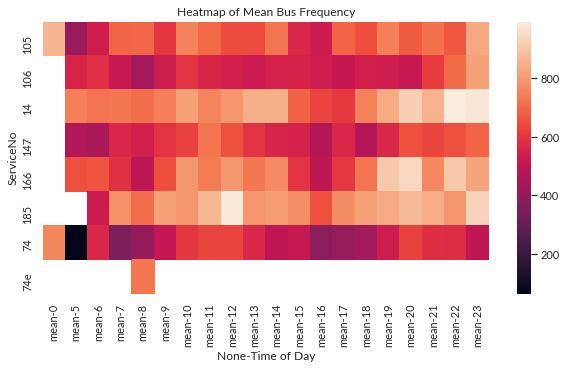

In [103]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.heatmap(bus_arrival_pivot, ax = ax)
ax.set_title("Heatmap of Mean Bus Frequency")
fig.show()

### Checking for Outliers

Outliers in Series (First 5)
    ServiceNo Operator  NextBus.EstimatedArrival  NextBus.VisitNumber  \
104       105     SBST 2021-02-06 08:12:02+08:00                  1.0   
151       185     SBST 2021-02-06 09:45:58+08:00                  1.0   
193       185     SBST 2021-02-06 11:09:50+08:00                  1.0   
221       185     SBST 2021-02-06 12:05:14+08:00                  1.0   
431       185     SBST 2021-02-06 19:41:03+08:00                  1.0   

    NextBus.Load NextBus.Feature NextBus.Type NextBus2.EstimatedArrival  \
104          SEA             WAB           SD 2021-02-06 08:41:44+08:00   
151          SEA             WAB           DD 2021-02-06 10:10:10+08:00   
193          SEA             WAB           DD 2021-02-06 11:31:45+08:00   
221          SEA             WAB           DD 2021-02-06 12:26:44+08:00   
431          SEA             WAB           DD 2021-02-06 20:00:18+08:00   

     NextBus2.VisitNumber NextBus2.Load  ... NextBus2.Type  \
104                

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


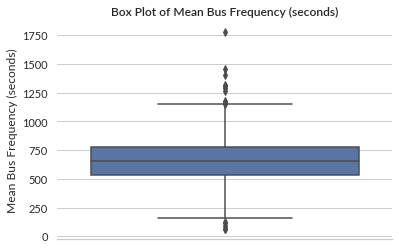

In [104]:
bus_freq_outliers = outlierDetection(bus_arrival_df, "Mean Bus Frequency (seconds)")

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tienc\miniconda3\li

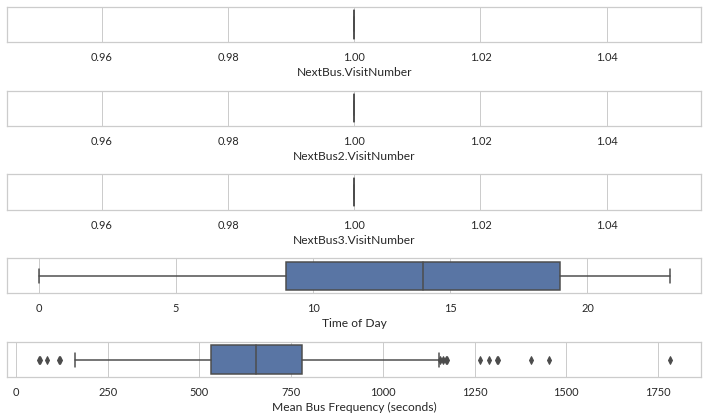

In [105]:
fig = plotAllOutliers(bus_arrival_df)
fig.savefig("./plots/outlier5.png", dpi = 200)

In [106]:
bus_freq_outliers.groupby(["Day of Week", "Time of Day"])[["Mean Bus Frequency (seconds)"]].mean()

Mean Bus Frequency (seconds)
Day of Week Time of Day                              
Monday      5                                    62.0
            16                                  118.0
            19                                   85.5
            20                                 1264.0
Saturday    8                                  1782.0
            9                                  1452.0
            11                                 1315.0
            12                                 1290.0
            19                                 1155.0
            20                                 1311.0
Sunday      10                                 1172.5
            20                                 1403.0
Tuesday     7                                   120.5
            23                                 1164.0
Wednesday   5                                    65.0
            14                                 1174.5

While some of these outliers are expected (high waiting time for buses in Weekends), some bus frequencies are too low or too high.

For instance, it is unlikely that mean bus frequency is 65 seconds at 5pm on Wednesday.

Instead, this calculation likely indicates something known as [bus bunching](https://landtransportguru.net/bus-bunching/), where due to delays somewhere along the route, two buses of the same service arrive almost at the same time. 

"Bus bunching is a scenario when **two or more buses along the same bus route arrive together (or a short distance from each other)**, instead of being evenly spaced apart. In such an instance, at least one of the buses has deviated off their scheduled timetable by a large margin.

Bunching occurs as one or more vehicle is unable to keep to their schedule, and as a result, **passengers along the route experience longer waiting times**. Often, bunching results in an overcrowded front bus followed by a rear bus with substantially lower passenger loading." 

-[Land Transport Guru](https://landtransportguru.net/bus-bunching/)

When this occurs, the expected arrival time will be very close to each other, causing the mean frequency to be unexpectedly low once calculated. It can also cause high mean frequency later on for buses coming afterwards. The presence of these outliers does provide additional info: some buses going to SP may be deviating from their bus schedule.

In order for our estimate of bus frequencies to be more accurate, we need to correct for this:

In [107]:
bus_arrival_df_no_outliers = bus_arrival_df.copy()
bus_arrival_df_no_outliers["Mean Bus Frequency (seconds)"] = removeOutliers(bus_arrival_df, ["Mean Bus Frequency (seconds)"])

Shape Before Removing Outliers: (1355, 1)
Shape After Removing Outliers: (1339, 1)


Outliers in Series (First 5)
     ServiceNo Operator  NextBus.EstimatedArrival  NextBus.VisitNumber  \
305        185     SBST 2021-02-06 15:14:34+08:00                  1.0   
1066       185     SBST 2021-02-07 23:45:38+08:00                  1.0   
1396       147     SBST 2021-02-08 16:37:47+08:00                  1.0   

     NextBus.Load NextBus.Feature NextBus.Type NextBus2.EstimatedArrival  \
305           SEA             WAB           SD 2021-02-06 15:33:46+08:00   
1066          SEA             WAB           DD 2021-02-08 00:04:49+08:00   
1396          SEA             WAB           DD 2021-02-08 16:39:50+08:00   

      NextBus2.VisitNumber NextBus2.Load  ... NextBus2.Type  \
305                    1.0           SEA  ...            DD   
1066                   1.0           SEA  ...            SD   
1396                   1.0           SEA  ...            DD   

     NextBus3.EstimatedArrival NextBus3.VisitNumber  NextBus3.Load  \
305                        NaT                

C:\Users\tienc\miniconda3\lib\site-packages\seaborn\_core.py:1312: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


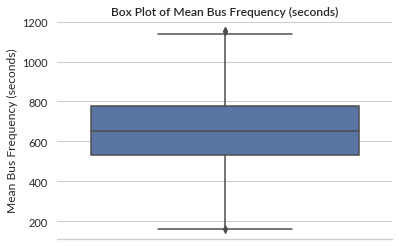

In [108]:
bus_freq_outliers = outlierDetection(bus_arrival_df_no_outliers, "Mean Bus Frequency (seconds)")

### Final Dataset Output 2: Bus Arrival

In [109]:
bus_arrival_df_no_outliers.to_csv("./output/bus_arrival_no_outliers.csv")
bus_arrival_with_na.to_csv("./output/bus_arrival_with_null_values.csv") # to do countplot

### Data Analysis

#### What is the distribution of mean bus frequency?

<ipython-input-110-ff8645546c2f>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


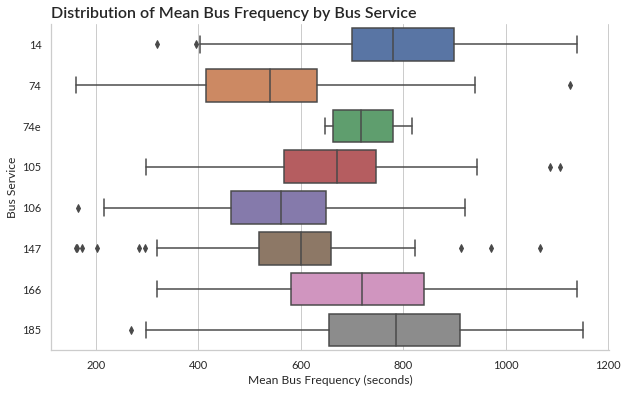

In [110]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.boxplot(x = "Mean Bus Frequency (seconds)",y="ServiceNo", data = bus_arrival_df_no_outliers, ax= ax, order = ['14', '74', '74e', '105', '106', '147', '166', '185'])
ax.set_title("Distribution of Mean Bus Frequency by Bus Service", loc="left", weight="semibold", fontsize = 16)
ax.set_ylabel("Bus Service")
sns.despine()
fig.show()
fig.savefig("./plots/bus_freq_box.png", dpi = 200)

#### Insights
- Distributions tend to be centered around 550 to 800 seconds (approx 9 to 13 minutes)
- IQR of Bus Service 74e (express) is the lowest (around 100). It is likely that as an express bus service, the bus schedule and number of bus stops is more tightly controlled and optimized for faster service, which allows for bus frequency to be more consistent. While the median frequency is not the lowest, the more consistent frequency is more preferable, as it reduces likelihood of bus bunching (as observed earlier). [Reference](https://landtransportguru.net/express-bus-services/)
- Based on LTA’s promise that all buses should have a frequency of 15 minutes (900 seconds) or less during peak periods, we observe that services 185, 166 and 14 which have an upper quartile close to 900, may need to improve their bus frequency to reduce chance of overcrowding.
- A similar idea to an express bus service would be a shuttle bus, which operates similarily to an express bus service in that it can save time by skipping unnecessary bus stops. The idea of operating a shuttle service is not new: Ngee Ann Polytechnic and NTU are examples of IHLs that operate shuttle buses. 
- Hence, a possible idea to improve bus connectivity to SP is to operate shuttle buses to take people from further away to SP. 

#### How does Bus Frequency Compare with the Demand?

In [111]:
bus_only = sp_only[sp_only["Mode of Travel"] == "BUS"]
bus_only.head()

,Year-Month,Day Type,Time of Day,Mode of Travel,PT_CODE,Hourly Tap In Volume,Hourly Tap Out Volume,Total Volume,Net Volume,Name,Time Interval
360,2020-10,WEEKDAY,8,BUS,19039,4265,5642,9907,-1377,Dover Bus Stop,Morning
361,2020-10,WEEKENDS/HOLIDAY,8,BUS,19039,896,642,1538,254,Dover Bus Stop,Morning
362,2020-10,WEEKDAY,20,BUS,19039,2674,594,3268,2080,Dover Bus Stop,Evening
363,2020-10,WEEKENDS/HOLIDAY,20,BUS,19039,1064,215,1279,849,Dover Bus Stop,Evening
364,2020-10,WEEKENDS/HOLIDAY,22,BUS,19039,743,151,894,592,Dover Bus Stop,Evening


<ipython-input-114-4760b95c2867>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


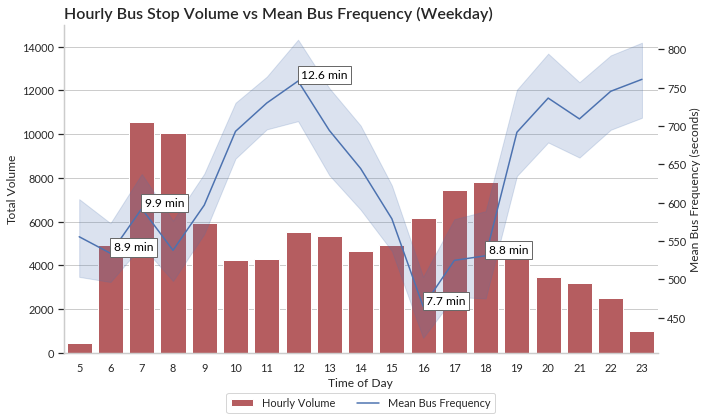

In [114]:
# Subset to 5am and after
bus_arrival_filtered = bus_arrival_df_no_outliers[(bus_arrival_df_no_outliers["Time of Day"] >= 5) & (~(bus_arrival_df_no_outliers["Day of Week"].isin(["Saturday", "Sunday"])))]
bus_volume_sp_filtered = bus_only[(bus_only["Time of Day"] >= 5) & (bus_only["Day Type"] == "WEEKDAY")]

# Plotting
fig, ax = plt.subplots(figsize = (10, 6), tight_layout = True)
ax2 = ax.twinx()
# ax.set_xticks(bus_arrival_filtered["Time of Day"].unique())
line_plot = sns.lineplot(x= bus_arrival_filtered["Time of Day"] - 5,y= "Mean Bus Frequency (seconds)",data = bus_arrival_filtered, ax = ax2, ci = 95, label="Mean Bus Frequency", legend = False) # -5 as bar plot in seaborn always starts axis from 0, meaning first value (even if it is a number), will always be 0. Thus to align the lineplot, I need to -5 from all values, so the smallest value (5) is read as a 0.
sns.barplot(x = "Time of Day", y = "Total Volume", data = bus_volume_sp_filtered, palette=["r"], ax = ax, ci = False, label="Hourly Volume")

# Annotation and Visuals
ax.set_title("Hourly Bus Stop Volume vs Mean Bus Frequency (Weekday)", loc = "left",weight = "semibold", fontsize = 16)
ax2.grid(None)
ax.set_ylim(0, 15000) # make lineplot higher up so they don't intersect
sns.despine()

linesAx, labelsAx = ax.get_legend_handles_labels()
linesAx2, labelsAx2 = ax2.get_legend_handles_labels()
ax.legend(linesAx + linesAx2, labelsAx + labelsAx2, bbox_to_anchor=(0.5, -0.2), loc="lower center", ncol = 2)
line_annot = [ax2.text(s = f"{y / 60:.1f} min", x= x - 4.9, y = y + 3, color = "black", bbox = bbox) for x, y in bus_arrival_filtered.groupby("Time of Day").mean()["Mean Bus Frequency (seconds)"].iloc[[1, 2, 7, 11, 13]].iteritems()] # Annotate bus frequency
fig.show()
fig.savefig("./plots/volume_vs_freq.png", dpi = 200)

In [115]:
bus_arrival_filtered.groupby("Time of Day").mean()

,NextBus.VisitNumber,NextBus2.VisitNumber,NextBus3.VisitNumber,Mean Bus Frequency (seconds)
Time of Day,,,,
5,1.0,1.0,1.0,555.652174
6,1.0,1.0,1.0,534.056604
7,1.0,1.0,1.0,592.336364
8,1.0,1.0,1.0,537.991667
9,1.0,1.0,1.0,596.918367
10,1.0,1.0,1.0,693.202381
11,1.0,1.0,1.0,730.166667
12,1.0,1.0,1.0,758.797619
13,1.0,1.0,1.0,694.416667


In [116]:
bus_volume_sp_filtered.groupby("Time of Day")["Total Volume"].mean()

Time of Day
5       429.333333
6      4912.666667
7     10548.666667
8     10031.666667
9      5946.666667
10     4225.333333
11     4282.333333
12     5528.666667
13     5343.000000
14     4634.000000
15     4914.333333
16     6176.333333
17     7456.333333
18     7797.000000
19     5031.666667
20     3473.000000
21     3183.000000
22     2523.333333
23      976.333333
Name: Total Volume, dtype: float64

#### Insights 
- There are two time periods where demand is the highest. 7am to 9am in the Morning, and 4pm to 7pm in the Evening. The peak bus stop volume is 10548.66 at 7am ($\approx$ 10549 people). The time of peak demand does differ from the MRT, as the morning peak demand for the MRT is at 8am, one hour later. Similarily, while the evening peak demand is at 6pm for buses, it was at 5pm for the MRT. The scale of the demand is also lower than for the MRT, suggesting most students take the MRT to school.
- In periods of higher demand, the mean bus frequency observed does decrease to approximately 8 to 10 minutes. However we note that at the time of peak demand (7:00am - 7:59am), the mean bus frequency observed increased by 1 minute to 9.9 minutes. This could indicate that the buses are facing increased strain during this period of time, thus there is a risk of overcrowding. According to LTA, under the Bus Contracting Model (where routes are tendered to different operators), frequencies at peak timings would be less than 15min for all servies, with about half being less than 10 minutes. This suggests the frequencies seen now during peak timing are better than average. 

#### Which Bus Services Are the Most Packed?

In [117]:
bus_arrival_filtered_load = bus_arrival_with_na[~(bus_arrival_with_na["Day of Week"].isin(["Saturday", "Sunday"]))]
load_df = bus_arrival_filtered_load.melt(id_vars ="ServiceNo",value_vars=["NextBus.Load", "NextBus2.Load", "NextBus3.Load"])
load_df = pd.crosstab(index = load_df["ServiceNo"], columns = load_df["value"]).sort_values(["SDA", "SEA"], ascending = True)
load_df.rename(columns = {
    "SDA" : "Standing Space Available",
    "SEA" : "Seats Available"
}, inplace = True)
load_df.tail()

value,Standing Space Available,Seats Available
ServiceNo,,
166,1,357
74,3,368
106,8,351
105,25,338
185,29,315


<ipython-input-118-c11a91f1890d>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


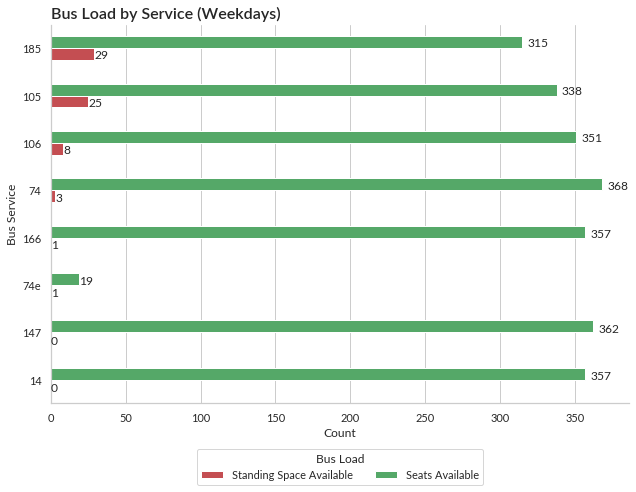

In [118]:
fig, ax = plt.subplots(figsize = (9, 7), tight_layout = True)
load_df.plot(kind = "barh", ax = ax, stacked = False, color = ["r", "g"])
ax.set_title("Bus Load by Service (Weekdays)", loc = "left", weight = "semibold", fontsize = 16)
ax.set_ylabel("Bus Service")
ax.set_xlabel("Count")
ax.grid(False, axis = "y")
ax.legend(title="Bus Load", bbox_to_anchor=(0.5, -0.23), loc="lower center", ncol = 2)
sns.despine()
annot = [ax.annotate(f"{p.get_width()}", (p.get_width() * 1.01, p.get_y() * 1.005)) for p in ax.patches]
fig.show()
fig.savefig("./plots/load_count.png", dpi = 200)

#### Insights 
- Overall, some bus services like 147, and 14, as based on the sample data collected, the load is always low. (0 occurrences of no seats available). These three routes go from East Singapore to West Singapore. Eg. 147 goes from Hougang to Clementi, 14 from Bedok to Clementi. 
- The Bus Services with the most occurrences of high load (standing space available only) during weekdays are Service No. 185 (9.39%), 105 (7.49%) and 106 (2.29%).  Based on Moovit route info, These three routes cover Western to Central Singapore. For instance 185 covers Pioneer to Buona Vista. 
- This suggests the demographic of people taking a bus to SP are mostly made up of people staying nearby (Western/Central area). This would make sense as those living further away would reach SP faster via the MRT.


<ipython-input-119-41dac967b403>:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


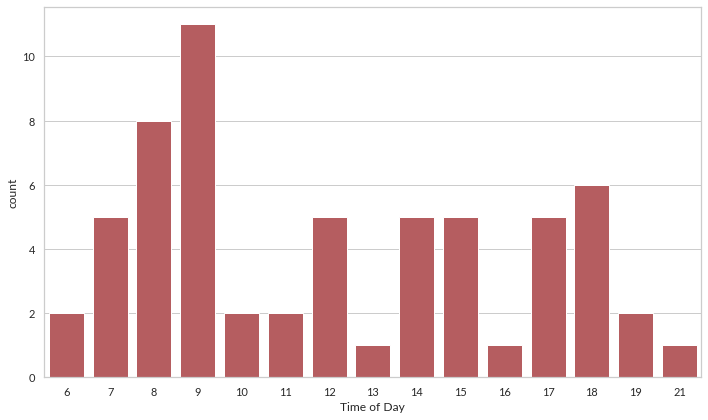

In [119]:
fig, ax = plt.subplots(figsize = (10, 6), tight_layout = True)
peak_load = bus_arrival_filtered[(bus_arrival_filtered["NextBus.Load"] == "SDA") | (bus_arrival_filtered["NextBus2.Load"] == "SDA") | (bus_arrival_filtered["NextBus3.Load"] == "SDA")]
sns.countplot(x = "Time of Day", data = peak_load, palette = ["r"], ax = ax)
fig.show()

As suspected, most occurances of high load take place in the morning, with the peak occurance at 9am period (> 10 occurances)

## Conclusion
- Peak demand for travel to and from SP occurs in the morning at 6am to 10am and in the evening from 4pm to 7pm. Morning peak hour sits between peak hour for Jurong East and Raffles Place.
- On Weekdays, net volume of Dover MRT is usually negative in the morning, and positive in the evening. 
- Most travel to SP by MRT instead of bus; Those that travel by bus seem to be those living in Central/West side of Singapore.
- Net demand differs by month; For months in more demanding academic terms, the increase in mean hourly total volume can be >1.5k
- Current bus frequencies are above average, but can be more consistent.


## Final Recommendations
### For MRT,
- SP can look into class timetables, to try and schedule classes such as to reduce number of 9am classes (causing peak 8am demand). This will spread out the demand reducing overcrowding.
- SP can also consider doing more home based learning in months closer to end of semester.
### For Buses,
- SP can look into operating shuttle buses which can run at higher frequency than typical buses serving SP (8 minutes per bus at peak hours) in the morning from 7am to 9am and in the afternoon from 5pm to 6pm. 
- SP can recommend that LTA look into how bus frequency could be made more consistent during 7am time period. A possible avenue would be to try and reduce occurance of bus bunching which was observed.
